# Load Package

In [3]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import shap
import statsmodels.api as sm
import traceback #



from google.colab import drive
drive.mount('/content/drive')


pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns


Mounted at /content/drive


# 1 - PRE process CSV

### CBG aggregate to Tracts (Demo+5d data)

In [ ]:
# prompt: 打开google doc同文件夹目录下的'CBG_selected_0411.csv'

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Assuming the file is in your Google Drive's My Drive folder.
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./CBG_selected_0411.csv'

try:
  df_cbg = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df_cbg.shape)
print(df_cbg.columns)
df_cbg.head()


(678, 40)
Index(['GEOID', 'crash_count', 'Area_km2', 'MedHHInc', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Ethics_div', 'MedRent', 'MedHVal', 'Population',
       'Building_d', 'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d',
       'Unemployme', 'Public', 'Commercial', 'Industrial', 'Residential',
       'Mixed.Use', 'commercial_density', 'tree_density', 'open_space_density',
       'intersection_density', 'road_density', 'traffic_signals_density',
       'parking_meter_density', 'Bus.Stop.Density', 'Bus.Line.Density',
       'Metro.Stop.Density', 'Metro.Line.Density', 'SVI', 'GVI', 'VEI', 'VMI',
       'VHI', 'avg_speed_limit'],
      dtype='object')


,GEOID,crash_count,Area_km2,MedHHInc,Whites,Black,Asian,Native_Ame,Ethics_div,MedRent,...,Bus.Stop.Density,Bus.Line.Density,Metro.Stop.Density,Metro.Line.Density,SVI,GVI,VEI,VMI,VHI,avg_speed_limit
0,60750101011,1,0.337754,115962.0,35.974843,15.220126,30.943396,6.037736,0.746192,2172.0,...,153.339142,43.112356,0.0,0.0,0.347173,0.065638,0.160441,0.447528,0.030147,19.720157
1,60750101012,1,0.158508,47431.0,34.690799,2.187029,49.095023,0.000000,0.635958,2108.0,...,65.348143,19.807163,0.0,0.0,0.283969,0.159041,0.239487,0.410848,0.030387,19.435768
2,60750101021,2,0.079646,NaN,25.733753,17.714885,40.618449,0.000000,0.719408,NaN,...,227.592850,33.650520,0.0,0.0,0.299172,0.090433,0.244236,0.419443,0.028863,17.075310
3,60750102011,1,0.124508,166023.0,66.776046,14.520098,9.844135,0.000000,0.522966,3311.0,...,103.990789,27.759383,0.0,0.0,0.337751,0.081702,0.197588,0.429120,0.023832,16.661156
4,60750102012,1,0.062219,146711.0,76.395534,0.637959,4.385965,0.000000,0.414408,2165.0,...,166.477982,21.663875,0.0,0.0,0.327007,0.067203,0.198808,0.431007,0.027207,16.833073


In [ ]:
# prompt: 将df_cbg 中‘GEOID’的前11位提取出来，赋予新的一列“Tract_ID”

df_cbg['Tract_ID'] = df_cbg['GEOID'].astype(str).str[:10]
df_cbg.head()

,GEOID,crash_count,Area_km2,MedHHInc,Whites,Black,Asian,Native_Ame,Ethics_div,MedRent,...,Bus.Line.Density,Metro.Stop.Density,Metro.Line.Density,SVI,GVI,VEI,VMI,VHI,avg_speed_limit,Tract_ID
0,60750101011,1,0.337754,115962.0,35.974843,15.220126,30.943396,6.037736,0.746192,2172.0,...,43.112356,0.0,0.0,0.347173,0.065638,0.160441,0.447528,0.030147,19.720157,6075010101
1,60750101012,1,0.158508,47431.0,34.690799,2.187029,49.095023,0.000000,0.635958,2108.0,...,19.807163,0.0,0.0,0.283969,0.159041,0.239487,0.410848,0.030387,19.435768,6075010101
2,60750101021,2,0.079646,NaN,25.733753,17.714885,40.618449,0.000000,0.719408,NaN,...,33.650520,0.0,0.0,0.299172,0.090433,0.244236,0.419443,0.028863,17.075310,6075010102
3,60750102011,1,0.124508,166023.0,66.776046,14.520098,9.844135,0.000000,0.522966,3311.0,...,27.759383,0.0,0.0,0.337751,0.081702,0.197588,0.429120,0.023832,16.661156,6075010201
4,60750102012,1,0.062219,146711.0,76.395534,0.637959,4.385965,0.000000,0.414408,2165.0,...,21.663875,0.0,0.0,0.327007,0.067203,0.198808,0.431007,0.027207,16.833073,6075010201


In [ ]:
import pandas as pd
import numpy as np # Import numpy for NaN handling

# Assume df_cbg is your DataFrame loaded previously and relevant columns
# have been converted to numeric using pd.to_numeric(errors='coerce')
# (as done in the previous step)

# Example placeholder DataFrame (ensure it's already numeric)

# Ensure columns are numeric (repeat from previous step if needed)
numeric_cols_needed = ['crash_count', 'Area_km2', 'MedHHInc', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Ethics_div', 'MedRent', 'MedHVal', 'Population',
       'Building_d', 'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d',
       'Unemployme', 'Public', 'Commercial', 'Industrial', 'Residential',
       'Mixed.Use', 'commercial_density', 'tree_density', 'open_space_density',
       'intersection_density', 'road_density', 'traffic_signals_density',
       'parking_meter_density', 'Bus.Stop.Density', 'Bus.Line.Density',
       'Metro.Stop.Density', 'Metro.Line.Density', 'SVI', 'GVI', 'VEI', 'VMI',
       'VHI', 'avg_speed_limit']
print("\n--- Ensuring columns are numeric ---")
for col in numeric_cols_needed:
    if col in df_cbg.columns:
        if not pd.api.types.is_numeric_dtype(df_cbg[col]):
             print(f"  Converting column '{col}' to numeric.")
             df_cbg[col] = pd.to_numeric(df_cbg[col], errors='coerce')
    else:
        print(f"  Warning: Column '{col}' listed for conversion not found in DataFrame.")
print("Data types checked/converted.")
print("-" * 30)


# --- Define a Helper Function for Weighted Average ---
def calculate_weighted_average(x, weight_col_name, source_df):
    """
    Calculates the weighted average for a Series 'x' based on weights
    from 'source_df' corresponding to the index of 'x'.

    Args:
        x (pd.Series): The data series for the current group/column.
        weight_col_name (str): The name of the column in source_df containing weights.
        source_df (pd.DataFrame): The original DataFrame to look up weights from.

    Returns:
        float or np.nan: The calculated weighted average, or NaN if calculation fails.
    """
    if x.empty:
        return np.nan # Handle empty groups

    try:
        # Get corresponding weights using the index of the current group's series 'x'
        # Use .reindex().fillna() for safety if index might not align perfectly
        weights = source_df.loc[x.index, weight_col_name].fillna(0)

        # Fill missing values in x with 0 for the calculation
        values_filled = x.fillna(0)

        # Calculate weighted sum and total weight
        weighted_sum = (values_filled * weights).sum()
        total_weight = weights.sum()

        # Calculate average, handling division by zero or NaN total weight
        if total_weight == 0 or pd.isna(total_weight):
            # Return NaN if weights sum to 0 or NaN
            return np.nan # You could return 0 here if that's more appropriate
        else:
            return weighted_sum / total_weight
    except KeyError:
        print(f"Error: Weight column '{weight_col_name}' not found for index {x.index.tolist()}")
        return np.nan
    except Exception as e:
        print(f"Error during weighted average calculation for index {x.index.tolist()}: {e}")
        return np.nan

#!!!
# --- Define Column Lists (Assuming defined earlier) ---
simple_sum_cols = ['crash_count', 'Area_km2', 'Population']

area_weighted_cols = ['Building_d', 'Felony_den', 'Misdemeano','Violation.','Homeless_d', 'Public', 'Commercial', 'Industrial', 'Residential',
       'Mixed.Use', 'commercial_density', 'tree_density', 'open_space_density',
       'intersection_density', 'road_density', 'traffic_signals_density',
       'parking_meter_density', 'Bus.Stop.Density', 'Bus.Line.Density',
       'Metro.Stop.Density', 'Metro.Line.Density', 'SVI', 'GVI', 'VEI', 'VMI',
       'VHI', 'avg_speed_limit']

pop_weighted_cols = ['Whites', 'Black','MedHHInc','Asian', 'Native_Ame', 'Unemployme', 'Ethics_div' ]

double_check_cols = ['MedRent', 'MedHVal', 'MedHHInc', 'avg_speed_limit']

grouping_col = 'Tract_ID'
exclude_cols = ['GEOID']
all_cols = df_cbg.columns.tolist()
handled_cols = simple_sum_cols + area_weighted_cols + pop_weighted_cols + exclude_cols + [grouping_col]
cols_to_aggregate = [col for col in all_cols if col in df_cbg.columns and col not in handled_cols]


# --- Build the aggregation dictionary using the helper function ---
agg_spec = {}

# 1. Simple sums
for col in simple_sum_cols:
    if col in df_cbg.columns:
        agg_spec[col] = (col, 'sum')

# 2. Area weighted averages - Use the helper function via lambda
for col in area_weighted_cols:
    if col in df_cbg.columns:
        # The lambda now just calls the function
        agg_spec[col] = (col, lambda x, weight_name='Area_km2', df=df_cbg:
                             calculate_weighted_average(x, weight_name, df))

# 3. Population weighted averages - Use the helper function via lambda
for col in pop_weighted_cols:
    if col in df_cbg.columns:
        # The lambda now just calls the function
        agg_spec[col] = (col, lambda x, weight_name='Population', df=df_cbg:
                             calculate_weighted_average(x, weight_name, df))

# 4. Sum the remaining columns
for col in cols_to_aggregate:
    if col in df_cbg.columns:
        agg_spec[col] = (col, 'sum')

# --- Perform the aggregation ---
print("\n--- Performing aggregation ---")
if not agg_spec:
    print("Warning: Aggregation specification is empty. No aggregation performed.")
    # Create minimal output with just the grouping key
    df_tract = pd.DataFrame({grouping_col: df_cbg[grouping_col].unique()})
else:
    try:
        df_tract = df_cbg.groupby(grouping_col).agg(**agg_spec)
        # Reset the index
        df_tract = df_tract.reset_index()
    except Exception as e:
        print(f"\nAn error occurred during groupby aggregation: {e}")
        print("Check the helper function and column data types.")
        # You might want to create an empty df_tract or re-raise the exception
        df_tract = pd.DataFrame()


# --- Print Results ---
print("\n--- Resulting df_tract ---")
print("Shape:", df_tract.shape)
print("Columns:", df_tract.columns)
print(df_tract.head())
print("-" * 30)


--- Ensuring columns are numeric ---
Data types checked/converted.
------------------------------

--- Performing aggregation ---

--- Resulting df_tract ---
Shape: (241, 40)
Columns: Index(['Tract_ID', 'crash_count', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residential', 'Mixed.Use',
       'commercial_density', 'tree_density', 'open_space_density',
       'intersection_density', 'road_density', 'traffic_signals_density',
       'parking_meter_density', 'Bus.Stop.Density', 'Bus.Line.Density',
       'Metro.Stop.Density', 'Metro.Line.Density', 'SVI', 'GVI', 'VEI', 'VMI',
       'VHI', 'avg_speed_limit', 'Whites', 'Black', 'MedHHInc', 'Asian',
       'Native_Ame', 'Unemployme', 'Ethics_div', 'MedRent', 'MedHVal'],
      dtype='object')
     Tract_ID  crash_count  Area_km2    Population  Building_d   Felony_den  \
0  6075010101            2  0.496261  10719.315170    0.337318   94

In [ ]:
print("Shape:", df_tract.shape)

df_tract.head()

Shape: (241, 40)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,avg_speed_limit,Whites,Black,MedHHInc,Asian,Native_Ame,Unemployme,Ethics_div,MedRent,MedHVal
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,19.629322,34.972754,5.048884,62479.290529,45.109221,1.325788,10.628988,0.660164,4280.0,1525900.0
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,17.075310,25.733753,17.714885,0.000000,40.618449,0.000000,0.690449,0.719408,0.0,1272500.0
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,16.718440,73.250442,5.176726,153025.060376,6.170514,0.000000,1.780247,0.449901,5476.0,3622100.0
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,17.660322,65.547755,4.066548,205486.068578,16.079989,0.000000,3.832691,0.530325,5774.0,2834600.0
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,15.502572,62.550357,0.000000,145877.920690,29.223445,1.912938,2.398591,0.504108,6012.0,1542400.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Assuming the file is in your Google Drive's My Drive folder.
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./HH value, rent.csv'

try:
  df_2 = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

df_2.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,GEO_ID,MedHHInc,MedRent,MedHVal
0,1400000US06075010902,137141,2866,"2,000,000"
1,1400000US06075011200,158750,2690,"2,000,000"
2,1400000US06075011700,93500,1648,"2,000,000"
3,1400000US06075012601,180123,3038,"2,000,000"
4,1400000US06075012700,236158,3202,"2,000,000"


In [ ]:
# prompt: 将df_cbg 中‘GEOID’的前11位提取出来，赋予新的一列“Tract_ID”

df_2['Tract_ID'] = df_2['GEO_ID'].astype(str).str[-10:]
df_2.head()

,GEO_ID,MedHHInc,MedRent,MedHVal,Tract_ID
0,1400000US06075010902,137141,2866,"2,000,000",6075010902
1,1400000US06075011200,158750,2690,"2,000,000",6075011200
2,1400000US06075011700,93500,1648,"2,000,000",6075011700
3,1400000US06075012601,180123,3038,"2,000,000",6075012601
4,1400000US06075012700,236158,3202,"2,000,000",6075012700


In [ ]:
# prompt: 将df_2的‘MedHHInc’，‘MedRent’，‘MedHVal’替换掉df_tract中的同名columns。根据‘Tract_ID’作为链接key

# Merge the dataframes
df_tract = pd.merge(df_tract, df_2[['Tract_ID', 'MedHHInc', 'MedRent', 'MedHVal']], on='Tract_ID', how='left')

# Replace values in df_tract with values from df_2
df_tract['MedHHInc'] = df_tract['MedHHInc_y'].fillna(df_tract['MedHHInc_x'])
df_tract['MedRent'] = df_tract['MedRent_y'].fillna(df_tract['MedRent_x'])
df_tract['MedHVal'] = df_tract['MedHVal_y'].fillna(df_tract['MedHVal_x'])

# Drop unnecessary columns
df_tract = df_tract.drop(columns=['MedHHInc_x', 'MedHHInc_y', 'MedRent_x', 'MedRent_y', 'MedHVal_x', 'MedHVal_y'])

print(df_tract.shape)
df_tract.head()


(241, 40)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,avg_speed_limit,Whites,Black,Asian,Native_Ame,Unemployme,Ethics_div,MedHHInc,MedRent,MedHVal
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,19.629322,34.972754,5.048884,45.109221,1.325788,10.628988,0.660164,83816,2144,1590500
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,17.075310,25.733753,17.714885,40.618449,0.000000,0.690449,0.719408,-,-,1272500
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,16.718440,73.250442,5.176726,6.170514,0.000000,1.780247,0.449901,147427,3073,1814400
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,17.660322,65.547755,4.066548,16.079989,0.000000,3.832691,0.530325,208750,2867,1415700
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,15.502572,62.550357,0.000000,29.223445,1.912938,2.398591,0.504108,149766,2119,1142900


In [ ]:
# prompt: 保存df_tract为“Tract_0421”

# Save the DataFrame to a CSV file in your Google Drive
output_file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Tract_0421.csv'
df_tract.to_csv(output_file_path, index=False)  # index=False prevents writing row indices
print(f"DataFrame saved to: {output_file_path}")


DataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Tract_0421.csv


## AV Trip Data to Tracts

### PRE process AV trips

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AVTrips/2024 SUM.csv'

try:
  df_av20243 = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")
df_av2024=df_av20243
print(df_av2024.shape)

df_av2024.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1351, 21)


,Tract,1202403,1202404,1202405,1202406,1202407,1202408,1202409,1202410,1202411,...,2202403,2202404,2202405,2202406,2202407,2202408,2202409,22024010,2202411,2202412
0,6037139702,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6037141500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6037141600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6037141700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6037143700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AVTrips/2023 SUM.csv'
try:
  df_av2023 = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

print(df_av2023.shape)
df_av2023.head()

(203, 15)


,Tract,1202308,1202309,1202310,1202311,1202312,1202401,1202402,2202308,2202309,2202310,2202311,2202312,2202401,2202402
0,6075010100,90,259,523,667,900,905,948,106,267,582,615,898,909,960
1,6075010200,50,204,444,486,748,783,755,46,211,439,499,794,785,735
2,6075010300,89,135,254,252,375,410,387,74,123,249,213,326,352,359
3,6075010400,48,75,229,178,341,321,359,44,85,281,230,366,375,392
4,6075010500,97,406,991,884,1402,1569,1379,105,393,997,937,1373,1506,1499


In [ ]:
# prompt: 将df_av2023join到df_av2024上去，key = 'Tract'。

# Merge the two dataframes
df_av = pd.merge(df_av2024, df_av2023, on='Tract', how='left')
df_av

,Tract,1202403,1202404,1202405,1202406,1202407,1202408,1202409,1202410,1202411,...,1202312,1202401,1202402,2202308,2202309,2202310,2202311,2202312,2202401,2202402
0,6037139702,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6037141500,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6037141600,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6037141700,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6037143700,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,6085511702,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1347,6085511704,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1348,6085511705,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1349,6085511707,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# prompt: df_av中的NaN全部替换为 整数格式的0

# Replace NaN values in df_av with 0
df_av = df_av.fillna(0)
print(df_av.columns)

df_av

Index(['Tract', '1202403', '1202404', '1202405', '1202406', '1202407',
       '1202408', '1202409', '1202410', '1202411', '1202412', '2202403',
       '2202404', '2202405', '2202406', '2202407', '2202408', '2202409',
       '22024010', '2202411', '2202412', '1202308', '1202309', '1202310',
       '1202311', '1202312', '1202401', '1202402', '2202308', '2202309',
       '2202310', '2202311', '2202312', '2202401', '2202402'],
      dtype='object')


,Tract,1202403,1202404,1202405,1202406,1202407,1202408,1202409,1202410,1202411,...,1202312,1202401,1202402,2202308,2202309,2202310,2202311,2202312,2202401,2202402
0,6037139702,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6037141500,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6037141600,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6037141700,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6037143700,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,6085511702,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1347,6085511704,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1348,6085511705,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,6085511707,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# prompt: 将df_av每行的'1202401', '1202402', '1202403', '1202404', '1202405', '1202406', '1202407',  '1202408', '1202409', '1202410', '1202411', '1202412', '1202308', '1202309', '1202310', '1202311', '1202312'的值去掉‘,’转换为float再求和并赋值给列“TripStart”
# 将df_av每行的'2202403', '2202404', '2202405', '2202406', '2202407', '2202408', '2202409', '22024010', '2202411', '2202412', '2202402', '2202401', '2202312', '2202308', '2202309', '2202310', '2202311'的值去掉‘,’转换为float再求和并赋值给列“TripEnd”

cols_to_sum_trip_start = ['1202401', '1202402', '1202403', '1202404', '1202405', '1202406', '1202407',  '1202408', '1202409', '1202410', '1202411', '1202412', '1202308', '1202309', '1202310', '1202311', '1202312']
cols_to_sum_trip_end = ['2202403', '2202404', '2202405', '2202406', '2202407', '2202408', '2202409', '22024010', '2202411', '2202412', '2202402', '2202401', '2202312', '2202308', '2202309', '2202310', '2202311']

df_av['TripStart'] = df_av[cols_to_sum_trip_start].apply(lambda row: sum([float(str(x).replace(',', '')) for x in row if pd.notna(x)]), axis=1)
df_av['TripEnd'] = df_av[cols_to_sum_trip_end].apply(lambda row: sum([float(str(x).replace(',', '')) for x in row if pd.notna(x)]), axis=1)


In [ ]:
print(df_av.shape)

df_av.head()

(1351, 37)


,Tract,1202403,1202404,1202405,1202406,1202407,1202408,1202409,1202410,1202411,...,1202402,2202308,2202309,2202310,2202311,2202312,2202401,2202402,TripStart,TripEnd
0,6037139702,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6037141500,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6037141600,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6037141700,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6037143700,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# prompt: 保存df_tract为“Tract_0421”

# Save the DataFrame to a CSV file in your Google Drive
output_file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Trips_Tract_0421.csv'
df_av.to_csv(output_file_path, index=False)  # index=False prevents writing row indices
print(f"DataFrame saved to: {output_file_path}")


DataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Trips_Tract_0421.csv


### Join AV Trip to Tracts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Assuming the file is in your Google Drive's My Drive folder.
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Tract_0421.csv'

try:
  df_tract = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

print(df_tract.shape)
df_tract.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(241, 40)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,avg_speed_limit,Whites,Black,Asian,Native_Ame,Unemployme,Ethics_div,MedHHInc,MedRent,MedHVal
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,19.629322,34.972754,5.048884,45.109221,1.325788,10.628988,0.660164,83816,2144,1590500
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,17.075310,25.733753,17.714885,40.618449,0.000000,0.690449,0.719408,-,-,1272500
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,16.718440,73.250442,5.176726,6.170514,0.000000,1.780247,0.449901,147427,3073,1814400
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,17.660322,65.547755,4.066548,16.079989,0.000000,3.832691,0.530325,208750,2867,1415700
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,15.502572,62.550357,0.000000,29.223445,1.912938,2.398591,0.504108,149766,2119,1142900


In [ ]:
# prompt: 将df_av的两列 ‘TripStart’ and 'TripEnd' 的 join到df_tract上去，key ='Tract_ID' and 'Tract'。执行之前先把'Tract_ID' and 'Tract'转为str

# Convert 'Tract_ID' and 'Tract' columns to string type
df_tract['Tract_ID'] = df_tract['Tract_ID'].astype(str)
df_av['Tract'] = df_av['Tract'].astype(str)

# Merge the dataframes
df_tract_merge = pd.merge(df_tract, df_av[['Tract', 'TripStart', 'TripEnd']], left_on='Tract_ID', right_on='Tract', how='left')

# Replace NaN values in df_av with 0
df_tract_merge = df_tract_merge.fillna(0)

# Display the merged dataframe
print(df_tract_merge.shape)
df_tract_merge.head()


(241, 43)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,Asian,Native_Ame,Unemployme,Ethics_div,MedHHInc,MedRent,MedHVal,Tract,TripStart,TripEnd
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,45.109221,1.325788,10.628988,0.660164,83816,2144,1590500,0,0.0,0.0
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,40.618449,0.000000,0.690449,0.719408,-,-,1272500,0,0.0,0.0
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,6.170514,0.000000,1.780247,0.449901,147427,3073,1814400,0,0.0,0.0
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,16.079989,0.000000,3.832691,0.530325,208750,2867,1415700,0,0.0,0.0
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,29.223445,1.912938,2.398591,0.504108,149766,2119,1142900,6075010300,17777.0,14942.0


In [ ]:
# prompt: df_tract_merge删除 ‘TripStart’ ‘TripEnd’ 都等于0的行

# Drop rows where both 'TripStart' and 'TripEnd' are 0
# df_tract_select= df_tract_merge[(df_tract_merge['TripStart'] != 0) | (df_tract_merge['TripEnd'] != 0)]
df_tract_select = df_tract_merge
print(df_tract_select.shape)
df_tract_select


(241, 43)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,Asian,Native_Ame,Unemployme,Ethics_div,MedHHInc,MedRent,MedHVal,Tract,TripStart,TripEnd
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,45.109221,1.325788,10.628988,0.660164,83816,2144,1590500,0,0.0,0.0
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,40.618449,0.000000,0.690449,0.719408,-,-,1272500,0,0.0,0.0
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,6.170514,0.000000,1.780247,0.449901,147427,3073,1814400,0,0.0,0.0
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,16.079989,0.000000,3.832691,0.530325,208750,2867,1415700,0,0.0,0.0
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,29.223445,1.912938,2.398591,0.504108,149766,2119,1142900,6075010300,17777.0,14942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,6075980200,1,0.995024,186.930123,0.035993,25.125017,161.805107,15.075010,3.015002,99.877187,...,31.182796,0.000000,0.000000,0.714389,-,-,-,6075980200,2669.0,3865.0
237,6075980300,5,4.435202,8.567816,0.014561,50.279554,137.986936,45.770177,30.212826,99.844886,...,0.000000,0.000000,10.526316,0.601108,-,-,-,6075980300,21699.0,24323.0
238,6075980501,1,1.492338,86.441536,0.016485,50.256707,45.566081,28.143756,2.680358,97.509523,...,100.000000,0.000000,0.000000,0.000000,12169,275,-,6075980501,509.0,649.0
239,6075980600,1,1.834288,638.939934,0.118830,29.439212,39.797453,29.984383,2.725853,1.043239,...,35.921502,3.668942,4.011065,0.803763,136250,2000,717800,6075980600,687.0,795.0


In [ ]:

# Save the DataFrame to a CSV file in your Google Drive
output_file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AV_Tract_select_0425.csv'
df_tract_select.to_csv(output_file_path, index=False)  # index=False prevents writing row indices
print(f"DataFrame saved to: {output_file_path}")

DataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AV_Tract_select_0425.csv


## GVI Segmentation data to Tracts

In [ ]:
# LOAD GVI Segmentation data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Assuming the file is in your Google Drive's My Drive folder.
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./GVI Tracts 250426.csv'

try:
  df_GVI = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

print(df_GVI.shape)
df_GVI.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(244, 22)


,geoid,namelsad,geoID_,road_mean,sidewalk_m,building_m,wall_mean,fence_mean,pole_mean,traffic li,traffic si,vegetation,terrain_me,sky_mean,person_mea,rider_mean,car_mean,truck_mean,bus_mean,train_mean,motorcycle,bicycle_me
0,6075980501,Census Tract 9805.01,06075980501-,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6075017102,Census Tract 171.02,06075017102-,0.4,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6075012302,Census Tract 123.02,06075012302-,0.4,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6075016801,Census Tract 168.01,06075016801-,0.4,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6075011902,Census Tract 119.02,06075011902-,0.4,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Assuming the file is in your Google Drive's My Drive folder.
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AV_Tract_select_0425.csv'

try:
  df_tract_select = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

print(df_tract_select.shape)
df_tract_select.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(241, 43)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,Asian,Native_Ame,Unemployme,Ethics_div,MedHHInc,MedRent,MedHVal,Tract,TripStart,TripEnd
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,45.109221,1.325788,10.628988,0.660164,83816,2144,1590500,0,0.0,0.0
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,40.618449,0.000000,0.690449,0.719408,-,-,1272500,0,0.0,0.0
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,6.170514,0.000000,1.780247,0.449901,147427,3073,1814400,0,0.0,0.0
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,16.079989,0.000000,3.832691,0.530325,208750,2867,1415700,0,0.0,0.0
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,29.223445,1.912938,2.398591,0.504108,149766,2119,1142900,6075010300,17777.0,14942.0


In [ ]:
print("Columns:", df_GVI.columns)


Columns: Index(['geoid', 'namelsad', 'geoID_', 'road_mean', 'sidewalk_m', 'building_m',
       'wall_mean', 'fence_mean', 'pole_mean', 'traffic li', 'traffic si',
       'vegetation', 'terrain_me', 'sky_mean', 'person_mea', 'rider_mean',
       'car_mean', 'truck_mean', 'bus_mean', 'train_mean', 'motorcycle',
       'bicycle_me'],
      dtype='object')


In [ ]:
# Rename columns in df_GVI
rename_dict = {
    'road_mean': 'SVI_road',
    'sidewalk_m': 'SVI_sidewalk',
    'building_m': 'SVI_building',
    'wall_mean': 'SVI_wall',
    'fence_mean': 'SVI_fence',
    'pole_mean': 'SVI_pole',
    'traffic li': 'SVI_traffic_light',
    'traffic si': 'SVI_traffic_signal',
    'vegetation': 'SVI_vegetation',
    'terrain_me': 'SVI_terrain',
    'sky_mean': 'SVI_sky',
    'person_mea': 'SVI_person',
    'rider_mean': 'SVI_rider',
    'car_mean': 'SVI_car',
    'truck_mean': 'SVI_truck',
    'bus_mean': 'SVI_bus',
    'train_mean': 'SVI_train',
    'motorcycle': 'SVI_motorcycle',
    'bicycle_me': 'SVI_bicycle'
}

df_GVIz = df_GVI.rename(columns=rename_dict)

# Now df_GVIz has the renamed columns
df_GVIz.columns


Index(['geoid', 'namelsad', 'geoID_', 'SVI_road', 'SVI_sidewalk',
       'SVI_building', 'SVI_wall', 'SVI_fence', 'SVI_pole',
       'SVI_traffic_light', 'SVI_traffic_signal', 'SVI_vegetation',
       'SVI_terrain', 'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car',
       'SVI_truck', 'SVI_bus', 'SVI_train', 'SVI_motorcycle', 'SVI_bicycle'],
      dtype='object')

### Save renamed GVI csv

In [ ]:
# Save the DataFrame to a CSV file in your Google Drive
output_file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./GVI Tracts 250427.csv'
df_GVIz.to_csv(output_file_path, index=False)  # index=False prevents writing row indices
print(f"DataFrame saved to: {output_file_path}")

DataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./GVI Tracts 250427.csv


In [ ]:
#  JOIN df_GVI join to df_tract_select

# Merge the dataframes
df_tract_select = pd.merge(df_tract_select, df_GVIz[['geoid', 'SVI_road', 'SVI_sidewalk',
       'SVI_building', 'SVI_wall', 'SVI_fence', 'SVI_pole',
       'SVI_traffic_light', 'SVI_traffic_signal', 'SVI_vegetation',
       'SVI_terrain', 'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car',
       'SVI_truck', 'SVI_bus', 'SVI_train', 'SVI_motorcycle', 'SVI_bicycle']], left_on='Tract_ID', right_on='geoid', how='left')

# Display the merged dataframe
print(df_tract_select.shape)
df_tract_select.head()


(241, 63)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,SVI_terrain,SVI_sky,SVI_person,SVI_rider,SVI_car,SVI_truck,SVI_bus,SVI_train,SVI_motorcycle,SVI_bicycle
0,6075010101,2,0.496261,10719.315170,0.337318,945.066784,5233.130996,477.571061,173.295828,17.755141,...,0.005013,0.341120,0.002412,0.000317,0.023251,0.000931,0.001851,0.001774,0.000511,0.000243
1,6075010102,2,0.079646,23956.105850,0.462815,1544.340157,3528.126700,904.003994,326.445887,0.004193,...,0.001865,0.310988,0.001684,0.000128,0.029731,0.000619,0.000917,0.000433,0.000182,0.000138
2,6075010201,2,0.186727,29945.076121,0.381486,337.390711,1360.273659,166.017651,58.909489,8.228874,...,0.003159,0.332698,0.000868,0.000155,0.026692,0.000540,0.000523,0.000836,0.000152,0.000061
3,6075010202,2,0.378439,11193.727763,0.263643,546.984386,2930.462245,367.298694,97.770156,31.802755,...,0.008077,0.344948,0.002107,0.000329,0.021439,0.000628,0.001579,0.000721,0.000149,0.000419
4,6075010300,5,0.267551,47669.612100,0.415654,343.859247,1113.804952,250.419234,59.801608,3.857807,...,0.001346,0.319983,0.000664,0.000183,0.029116,0.000741,0.000266,0.000217,0.000147,0.000114


In [ ]:
# Save the DataFrame to a CSV file in your Google Drive
output_file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AV_Tract_select_GVI_0427.csv'
df_tract_select.to_csv(output_file_path, index=False)  # index=False prevents writing row indices
print(f"DataFrame saved to: {output_file_path}")

DataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AV_Tract_select_GVI_0427.csv


# 2 - PRE process SHAPE FILE

In [191]:
# prompt: 打开google doc同文件夹目录下的'CBG_selected_0411.csv'

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Assuming the file is in your Google Drive's My Drive folder.
# Adjust the path if the file is in a different location within your Drive.
file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./AV_Tract_select_GVI_0427.csv'

try:
  df_tract_select = pd.read_csv(file_path)
  print(df_tract_select.shape)

except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

df_tract_select.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(241, 63)


,Tract_ID,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,SVI_terrain,SVI_sky,SVI_person,SVI_rider,SVI_car,SVI_truck,SVI_bus,SVI_train,SVI_motorcycle,SVI_bicycle
0,6075010101,2,0.5,10719.3,0.3,945.1,5233.1,477.6,173.3,17.8,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6075010102,2,0.1,23956.1,0.5,1544.3,3528.1,904.0,326.4,0.0,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6075010201,2,0.2,29945.1,0.4,337.4,1360.3,166.0,58.9,8.2,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6075010202,2,0.4,11193.7,0.3,547.0,2930.5,367.3,97.8,31.8,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6075010300,5,0.3,47669.6,0.4,343.9,1113.8,250.4,59.8,3.9,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
# prompt: 读取一个shape file (file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts.shp')

# Assuming file_path is defined as in your provided code.
file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/2020 Tracts for SF Clipped.shp'

try:
    gdf_tracts = gpd.read_file(file_path)
    print(gdf_tracts.shape)
    print(gdf_tracts.columns)
except FileNotFoundError:
    print(f"Error: Shapefile not found at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred while reading the shapefile: {e}")


(243, 59)
Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'commerci_1',
       'tree_densi', 'open_space', 'intersecti', 'road_densi', 'traffic_si',
       'parking_me', 'Bus.Stop.D', 'Bus.Line.D', 'Metro.Stop', 'Metro.Line',
       'avg_speed_', 'Whites', 'Black', 'Asian', 'Native_Ame', 'Unemployme',
       'Ethics_div', 'MedHHInc', 'MedRent', 'MedHVal', 'TripStart', 'TripEnd',
       'SVI_road', 'SVI_sidewa', 'SVI_buildi', 'SVI_wall', 'SVI_fence',
       'SVI_pole', 'SVI_traffi', 'SVI_traf_1', 'SVI_vegeta', 'SVI_terrai',
       'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car', 'SVI_truck', 'SVI_bus',
       'SVI_train', 'SVI_motorc', 'SVI_bicycl', 'TripStart_', 'TripEnd_de',
       'geometry'],
      dtype='object')


In [193]:
# prompt: gdf_tracts 'Tract_ID'= ''geoid'' 第二位到最后一位。然后仅仅保留column： 'Tract_ID' 和‘geometry’

import geopandas as gpd

# Assuming gdf_tracts is already loaded as in your provided code.
# ... (your existing code to load gdf_tracts) ...

# Extract the substring from the second character onwards
# gdf_tracts['Tract_ID'] = gdf_tracts['geoid'].astype(str).str[1:]

# Keep only the desired columns
gdf_tracts = gdf_tracts[['Tract_ID', 'geometry']]

# Now gdf_tracts contains only 'Tract_ID' and 'geometry' columns.
print(gdf_tracts.head())


     Tract_ID                                           geometry
0  6075980501  POLYGON ((-122.42722 37.71555, -122.42719 37.7...
1  6075017102  POLYGON ((-122.45321 37.76825, -122.45168 37.7...
2  6075012302  POLYGON ((-122.415 37.78745, -122.41335 37.787...
3  6075016801  POLYGON ((-122.43235 37.77378, -122.43082 37.7...
4  6075011902  POLYGON ((-122.41246 37.79163, -122.41171 37.7...


In [194]:
# prompt: 将df_tract_select' 的数据链接到gdf_tracts, key = 'Tract_ID'。

# Merge the dataframes
gdf_tracts = gdf_tracts.astype({'Tract_ID': 'str'})
df_tract_select = df_tract_select.astype({'Tract_ID': 'str'})
gdf_merged = gdf_tracts.merge(df_tract_select, on='Tract_ID', how='left')
gdf_merged.head()


,Tract_ID,geometry,crash_count,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,...,SVI_terrain,SVI_sky,SVI_person,SVI_rider,SVI_car,SVI_truck,SVI_bus,SVI_train,SVI_motorcycle,SVI_bicycle
0,6075980501,"POLYGON ((-122.42722 37.71555, -122.42719 37.7...",1.0,1.5,86.4,0.0,50.3,45.6,28.1,2.7,...,0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6075017102,"POLYGON ((-122.45321 37.76825, -122.45168 37.7...",3.0,0.3,37268.0,0.4,150.3,321.2,99.1,205.0,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6075012302,"POLYGON ((-122.415 37.78745, -122.41335 37.787...",4.0,0.1,123709.3,0.6,2203.7,2365.7,1371.9,1469.1,...,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6075016801,"POLYGON ((-122.43235 37.77378, -122.43082 37.7...",4.0,0.2,50173.8,0.4,674.1,864.8,466.3,517.2,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6075011902,"POLYGON ((-122.41246 37.79163, -122.41171 37.7...",4.0,0.1,99697.6,0.5,967.5,1386.7,451.5,301.0,...,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# Save the GeoDataFrame to a shapefile

output_shapefile_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250501.shp'
try:
    gdf_merged.to_file(output_shapefile_path)
    print(f"GeoDataFrame saved to: {output_shapefile_path}")
except Exception as e:
    print(f"An error occurred while saving the shapefile: {e}")


<ipython-input-195-4951539c7881>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_merged.to_file(output_shapefile_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'crash_count' to 'crash_coun'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Residential' to 'Residentia'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'commercial_density' to 'commerci_1'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tree_density' to 'tree_densi'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'open_space_density' to 'open_space'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogr

GeoDataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250501.shp


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030600 of field Tract of feature 159 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030600 of field geoid of feature 159 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030700 of field Tract of feature 160 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030700 of field geoid of feature 160 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030800 of field Tr

## Gini-Simpson Index Calculation

In [196]:
# prompt: 读取一个shape file (file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts.shp')

# Assuming file_path is defined as in your provided code.
file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250501.shp'

try:
    gdf_tracts = gpd.read_file(file_path)
    print(gdf_tracts.columns)
    print(gdf_tracts.shape)

except FileNotFoundError:
    print(f"Error: Shapefile not found at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred while reading the shapefile: {e}")


Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'commerci_1',
       'tree_densi', 'open_space', 'intersecti', 'road_densi', 'traffic_si',
       'parking_me', 'Bus.Stop.D', 'Bus.Line.D', 'Metro.Stop', 'Metro.Line',
       'SVI', 'GVI', 'VEI', 'VMI', 'VHI', 'avg_speed_', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Unemployme', 'Ethics_div', 'MedHHInc',
       'MedRent', 'MedHVal', 'Tract', 'TripStart', 'TripEnd', 'geoid',
       'SVI_road', 'SVI_sidewa', 'SVI_buildi', 'SVI_wall', 'SVI_fence',
       'SVI_pole', 'SVI_traffi', 'SVI_traf_1', 'SVI_vegeta', 'SVI_terrai',
       'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car', 'SVI_truck', 'SVI_bus',
       'SVI_train', 'SVI_motorc', 'SVI_bicycl', 'geometry'],
      dtype='object')
(243, 64)


In [197]:
# Calculate 1 - HHI (Gini-Simpson Index)

df_cleaned=gdf_tracts

def calculate_gini_simpson(series):
    """Calculates the Gini-Simpson index for a given series of land use proportions."""
    total_sum = series.sum()
    if total_sum == 0:  # Handle cases where the sum is zero
        return 0  # or np.nan if you prefer to represent it as missing data
    proportions = series / total_sum  # Calculate proportions
    hhi = (proportions**2).sum()
    gini_simpson_index = 1 - hhi
    return gini_simpson_index

# Apply the function to calculate the index for each tract
df_cleaned['Gini_Simpson'] = df_cleaned.apply(lambda row: calculate_gini_simpson(row[['Public', 'Commercial', 'Industrial', 'Residentia', 'Mixed.Use']]), axis=1)

# Display the results or further process as needed
print(df_cleaned[['Tract_ID', 'Gini_Simpson']].head())

     Tract_ID  Gini_Simpson
0  6075980501           0.0
1  6075017102           0.3
2  6075012302           0.5
3  6075016801           0.5
4  6075011902           0.3


In [198]:
# Save the GeoDataFrame to a shapefile

output_shapefile_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502.shp'
try:
    df_cleaned.to_file(output_shapefile_path)
    print(f"GeoDataFrame saved to: {output_shapefile_path}")
except Exception as e:
    print(f"An error occurred while saving the shapefile: {e}")


<ipython-input-198-9bfd279720e0>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_cleaned.to_file(output_shapefile_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gini_Simpson' to 'Gini_Simps'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075980501 of field Tract of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075980501 of field geoid of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075017102 of field Tract of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/

GeoDataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502.shp


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075017804 of field geoid of feature 165 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075017602 of field geoid of feature 166 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075061503 of field geoid of feature 167 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075060703 of field geoid of feature 168 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075061402 of field ge

## Calcu POI Diversity

In [199]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import entropy as scipy_entropy # Use scipy's entropy function

gdf_tracts=df_cleaned

# --- 1. Load  POI data from CSV
poi_csv_path =  '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./POI_SanFrancisco_combined.csv'
try:
    df_pois = pd.read_csv(poi_csv_path)
    print(f"POI data loaded successfully from {poi_csv_path}")
    # Basic validation
    if not all(col in df_pois.columns for col in ['LATITUDE', 'LONGITUDE', 'TOP_CATEGORY']):
        raise ValueError("CSV must contain 'LATITUDE', 'LONGITUDE', and 'TOP_CATEGORY' columns.")
except FileNotFoundError:
    print(f"Error: POI file not found at {poi_csv_path}")
    exit()
except Exception as e:
    print(f"Error loading POI CSV: {e}")
    exit()


# Ensure gdf_tracts exists and is a GeoDataFrame
if 'gdf_tracts' not in locals() or not isinstance(gdf_tracts, gpd.GeoDataFrame):
     print("Error: GeoDataFrame 'gdf_tracts' not found or not loaded correctly.")
     # Add loading code here if needed, or exit
     exit()

# --- 2. Prepare POI GeoDataFrame ---

# Convert the POI DataFrame to a GeoDataFrame
# Create geometry points from LATITUDE and LONGITUDE
geometry = gpd.points_from_xy(df_pois['LONGITUDE'], df_pois['LATITUDE'])

# Create the GeoDataFrame
# **IMPORTANT**: Set the initial CRS. WGS84 (EPSG:4326) is common for Lat/Lon.
# If your coordinates are in a different system, use the correct EPSG code.
initial_crs = "EPSG:4326"
gdf_pois = gpd.GeoDataFrame(df_pois, geometry=geometry, crs=initial_crs)
print(f"POI GeoDataFrame created with initial CRS: {gdf_pois.crs}")

# --- 3. Align Coordinate Reference Systems (CRS) ---

# Check if CRS match
if gdf_pois.crs != gdf_tracts.crs:
    print(f"CRS mismatch: POIs ({gdf_pois.crs}) vs Tracts ({gdf_tracts.crs}). Aligning POI CRS to Tracts CRS...")
    try:
        gdf_pois = gdf_pois.to_crs(gdf_tracts.crs)
        print(f"POI CRS successfully transformed to: {gdf_pois.crs}")
    except Exception as e:
        print(f"Error transforming POI CRS: {e}")
        exit()
else:
    print("CRS match. No transformation needed.")

# --- 4. Perform Spatial Join ---

# Spatially join POIs to the tract polygons they fall within
# 'inner' join keeps only POIs within a polygon
# 'op='within'' specifies the spatial relationship
# index_right='tract_index' (or similar) renames the index column from gdf_tracts for clarity
gdf_tracts_index_name = gdf_tracts.index.name if gdf_tracts.index.name else 'tract_index' # Use existing index name or default
gdf_joined = gpd.sjoin(gdf_pois, gdf_tracts, how='inner', predicate='within', rsuffix='tract')


print(f"Spatial join completed. {len(gdf_joined)} POIs fall within the tracts.")
# The index from gdf_tracts is typically added as 'index_tract' (due to rsuffix='tract')

# --- 5. Calculate Shannon Entropy per Polygon ---

def calculate_shannon_entropy(series):
    """Calculates Shannon entropy for a pandas Series of categories."""
    # Check for empty series (no POIs in polygon)
    if series.empty:
        return 0.0 # Entropy is 0 if there are no POIs

    # Get counts of each unique POI type
    counts = series.value_counts()

    # Check if only one type exists (entropy is 0)
    if len(counts) <= 1:
        return 0.0

    # Calculate entropy using scipy.stats.entropy (expects counts or probabilities)
    # It calculates H = -sum(pk * log(pk)), where pk = counts/sum(counts)
    # Using base=np.e for natural logarithm (nats)
    return scipy_entropy(counts, base=np.e)

# Group the joined GeoDataFrame by the tract index (which came from gdf_tracts)
# The index column from the right GeoDataFrame (gdf_tracts) is named 'index_tract'
tract_index_col = f'index_{gdf_tracts.index.name}' if gdf_tracts.index.name else 'index_tract' # Adjust if gdf_tracts had a named index before sjoin

if tract_index_col not in gdf_joined.columns:
     print(f"Error: Tract index column '{tract_index_col}' not found after spatial join.")
     print(f"Columns available: {gdf_joined.columns}")
     print("Make sure the index of gdf_tracts was preserved during the join.")
     # Attempt to use the default 'index_right' if it exists
     if 'index_right' in gdf_joined.columns:
          print("Trying default 'index_right'...")
          tract_index_col = 'index_right'
     else:
          exit()

print(f"Grouping by tract index column: '{tract_index_col}'")
# Calculate entropy for the 'TOP_CATEGORY' within each group (polygon)
entropy_series = gdf_joined.groupby(tract_index_col)['TOP_CATEGORY'].apply(calculate_shannon_entropy)

# --- 6. Add Entropy to Original Tracts GeoDataFrame ---

# Create the new column in the original gdf_tracts
entropy_col_name = 'poi_shannon_entropy'
gdf_tracts[entropy_col_name] = entropy_series

# Fill polygons that had no POIs (will be NaN after the map/join) with 0 entropy
gdf_tracts[entropy_col_name] = gdf_tracts[entropy_col_name].fillna(0)

print(f"\nShannon entropy calculated and added as column '{entropy_col_name}' to gdf_tracts.")
print("\nPreview of gdf_tracts with new entropy column:")
print(gdf_tracts[[gdf_tracts.geometry.name, entropy_col_name]].head())

# You can now save or use gdf_tracts with the added entropy column
# Example: gdf_tracts.to_file('tracts_with_poi_entropy.shp')

POI data loaded successfully from /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./POI_SanFrancisco_combined.csv
POI GeoDataFrame created with initial CRS: EPSG:4326
CRS match. No transformation needed.
Spatial join completed. 96201 POIs fall within the tracts.
Grouping by tract index column: 'index_tract'

Shannon entropy calculated and added as column 'poi_shannon_entropy' to gdf_tracts.

Preview of gdf_tracts with new entropy column:
                                            geometry  poi_shannon_entropy
0  POLYGON ((-122.42722 37.71555, -122.42719 37.7...                  1.8
1  POLYGON ((-122.45321 37.76825, -122.45168 37.7...                  3.2
2  POLYGON ((-122.415 37.78745, -122.41335 37.787...                  3.0
3  POLYGON ((-122.43235 37.77378, -122.43082 37.7...                  3.1
4  POLYGON ((-122.41246 37.79163, -122.41171 37.7...                  2.8


In [200]:
# Save the GeoDataFrame to a shapefile

df_cleaned = gdf_tracts
output_shapefile_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502_1.shp'
try:
    gdf_tracts.to_file(output_shapefile_path)
    print(f"GeoDataFrame saved to: {output_shapefile_path}")
except Exception as e:
    print(f"An error occurred while saving the shapefile: {e}")


<ipython-input-200-0977ab46477c>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_tracts.to_file(output_shapefile_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gini_Simpson' to 'Gini_Simps'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'poi_shannon_entropy' to 'poi_shanno'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075980501 of field Tract of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075980501 of field geoid of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: Run

GeoDataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502_1.shp


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075025502 of field geoid of feature 200 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075016101 of field geoid of feature 201 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075012403 of field geoid of feature 202 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075047903 of field geoid of feature 203 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075016102 of field ge

## GVI Calcu

In [201]:
print(df_cleaned.columns)
print(df_cleaned.shape)

Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'commerci_1',
       'tree_densi', 'open_space', 'intersecti', 'road_densi', 'traffic_si',
       'parking_me', 'Bus.Stop.D', 'Bus.Line.D', 'Metro.Stop', 'Metro.Line',
       'SVI', 'GVI', 'VEI', 'VMI', 'VHI', 'avg_speed_', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Unemployme', 'Ethics_div', 'MedHHInc',
       'MedRent', 'MedHVal', 'Tract', 'TripStart', 'TripEnd', 'geoid',
       'SVI_road', 'SVI_sidewa', 'SVI_buildi', 'SVI_wall', 'SVI_fence',
       'SVI_pole', 'SVI_traffi', 'SVI_traf_1', 'SVI_vegeta', 'SVI_terrai',
       'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car', 'SVI_truck', 'SVI_bus',
       'SVI_train', 'SVI_motorc', 'SVI_bicycl', 'geometry', 'Gini_Simpson',
       'poi_shannon_entropy'],
      dtype='object')
(243, 66)


In [202]:
import numpy as np

# 0. Street obstacles (街道障碍物: 墙壁、栅栏等的像素百分比)
# 使用 SVI_wall, SVI_fence 进行近似计算
obstacle_cols = ['SVI_wall', 'SVI_fence']
existing_obstacle_cols = [col for col in obstacle_cols if col in df_cleaned.columns]
if existing_obstacle_cols:
    df_cleaned['SVI_Obstacles'] = df_cleaned[existing_obstacle_cols].sum(axis=1)
    print("已计算: SVI_Obstacles")
else:
    print("跳过 SVI_Obstacles: 缺少必需的列。")

#1 Spatial walkability (The pixel percentage of sidewalks in roadways)
vis_enclosure_req_cols = ['SVI_road', 'SVI_sidewa']
if all(col in df_cleaned.columns for col in vis_enclosure_req_cols):
    # 计算分母，处理除以零的可能性
    denominator = df_cleaned['SVI_sidewa'] + df_cleaned['SVI_road']
    # 将分母中的 0 替换为 NaN (或一个极小的数) 以避免错误
    denominator = denominator.replace(0, np.nan)
    df_cleaned['SVI_Walkability'] = df_cleaned['SVI_sidewa'] / denominator
    # 可以选择性地处理计算产生的 NaN 值 (例如，填充为0)
    # df_cleaned['Visual_Enclosure'].fillna(0, inplace=True)
    print("已计算: SVI_Walkability (如果 人行道+道路=0，可能产生 NaN)")
else:
    print("跳过 SVI_Walkability: 缺少必需的列 (SVI_sidewa, SVI_road)。")


# 2. Street furniture (街道设施: 遮阳篷、长凳、路灯、交通灯、电线杆等的像素百分比)
# 使用 SVI_pole, SVI_traffi (交通灯), SVI_traf_1 (交通标志?) 进行近似计算
furniture_cols = ['SVI_pole', 'SVI_traffi', 'SVI_traf_l']
existing_furniture_cols = [col for col in furniture_cols if col in df_cleaned.columns]
if existing_furniture_cols:
    df_cleaned['SVI_Furniture'] = df_cleaned[existing_furniture_cols].sum(axis=1)
    print("已计算: SVI_Furniture")
else:
    print("跳过 SVI_Furniture: 缺少必需的列。")

# 3. Visual enclosure (视觉封闭度: 建筑物百分比 / (人行道百分比 + 道路百分比))
vis_enclosure_req_cols = ['SVI_buildi', 'SVI_sidewa', 'SVI_road']
if all(col in df_cleaned.columns for col in vis_enclosure_req_cols):
    # 计算分母，处理除以零的可能性
    denominator = df_cleaned['SVI_sidewa'] + df_cleaned['SVI_road']
    # 将分母中的 0 替换为 NaN (或一个极小的数) 以避免错误
    denominator = denominator.replace(0, np.nan)
    df_cleaned['SVI_Enclosure'] = df_cleaned['SVI_buildi'] / denominator
    # 可以选择性地处理计算产生的 NaN 值 (例如，填充为0)
    # df_cleaned['Visual_Enclosure'].fillna(0, inplace=True)
    print("已计算: SVI_Enclosure (如果 人行道+道路=0，可能产生 NaN)")
else:
    print("跳过 SVI_Enclosure: 缺少必需的列 (SVI_buildi, SVI_sidewa, SVI_road)。")


# 4. Transit stop Density  (bus + metro stop)
obstacle_cols = ['Bus.Stop.D', 'Metro.Stop.D']
existing_obstacle_cols = [col for col in obstacle_cols if col in df_cleaned.columns]
if existing_obstacle_cols:
    df_cleaned['TransitStop_Den'] = df_cleaned[existing_obstacle_cols].sum(axis=1)
    print("已计算: TransitStop_Den")
else:
    print("跳过 TransitStop_Density: 缺少必需的列。")

# 5. Crash Density  + Trip _density
df_cleaned['crash_den'] = df_cleaned['crash_coun']/df_cleaned['Area_km2']

df_cleaned['TripStart_D'] = df_cleaned['TripStart']/df_cleaned['Area_km2']
df_cleaned['TripEnd_de'] = df_cleaned['TripStart']/df_cleaned['Area_km2']


已计算: SVI_Obstacles
已计算: SVI_Walkability (如果 人行道+道路=0，可能产生 NaN)
已计算: SVI_Furniture
已计算: SVI_Enclosure (如果 人行道+道路=0，可能产生 NaN)
已计算: TransitStop_Den


In [203]:
print(df_cleaned.columns)
print(df_cleaned.shape)

Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'commerci_1',
       'tree_densi', 'open_space', 'intersecti', 'road_densi', 'traffic_si',
       'parking_me', 'Bus.Stop.D', 'Bus.Line.D', 'Metro.Stop', 'Metro.Line',
       'SVI', 'GVI', 'VEI', 'VMI', 'VHI', 'avg_speed_', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Unemployme', 'Ethics_div', 'MedHHInc',
       'MedRent', 'MedHVal', 'Tract', 'TripStart', 'TripEnd', 'geoid',
       'SVI_road', 'SVI_sidewa', 'SVI_buildi', 'SVI_wall', 'SVI_fence',
       'SVI_pole', 'SVI_traffi', 'SVI_traf_1', 'SVI_vegeta', 'SVI_terrai',
       'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car', 'SVI_truck', 'SVI_bus',
       'SVI_train', 'SVI_motorc', 'SVI_bicycl', 'geometry', 'Gini_Simpson',
       'poi_shannon_entropy', 'SVI_Obstacles', 'SVI_Walkability',
       'SVI_Furniture', 'SVI_Enclosure'

In [204]:
# Save the GeoDataFrame to a shapefile

output_shapefile_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502_2.shp'
try:
    df_cleaned.to_file(output_shapefile_path)
    print(f"GeoDataFrame saved to: {output_shapefile_path}")
except Exception as e:
    print(f"An error occurred while saving the shapefile: {e}")


<ipython-input-204-ae7abad2dc94>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_cleaned.to_file(output_shapefile_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gini_Simpson' to 'Gini_Simps'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'poi_shannon_entropy' to 'poi_shanno'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SVI_Obstacles' to 'SVI_Obstac'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SVI_Walkability' to 'SVI_Walkab'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SVI_Furniture' to 'SVI_Furnit'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyo

GeoDataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502_2.shp


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030302 of field Tract of feature 156 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030302 of field geoid of feature 156 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030400 of field Tract of feature 157 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030400 of field geoid of feature 157 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075030500 of field Tr

#3 -  Viz DATA


In [233]:
# prompt: 读取一个shape file (file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts.shp')
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive')

# Assuming file_path is defined as in your provided code.
file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250502_2.shp'

try:
    gdf_tracts = gpd.read_file(file_path)
except FileNotFoundError:
    print(f"Error: Shapefile not found at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred while reading the shapefile: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
print(gdf_tracts.shape)
print(gdf_tracts.columns)
gdf_tracts.head()

(243, 74)
Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'commerci_1',
       'tree_densi', 'open_space', 'intersecti', 'road_densi', 'traffic_si',
       'parking_me', 'Bus.Stop.D', 'Bus.Line.D', 'Metro.Stop', 'Metro.Line',
       'SVI', 'GVI', 'VEI', 'VMI', 'VHI', 'avg_speed_', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Unemployme', 'Ethics_div', 'MedHHInc',
       'MedRent', 'MedHVal', 'Tract', 'TripStart', 'TripEnd', 'geoid',
       'SVI_road', 'SVI_sidewa', 'SVI_buildi', 'SVI_wall', 'SVI_fence',
       'SVI_pole', 'SVI_traffi', 'SVI_traf_1', 'SVI_vegeta', 'SVI_terrai',
       'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car', 'SVI_truck', 'SVI_bus',
       'SVI_train', 'SVI_motorc', 'SVI_bicycl', 'Gini_Simps', 'poi_shanno',
       'SVI_Obstac', 'SVI_Walkab', 'SVI_Furnit', 'SVI_Enclos', 'TransitSto',
       'crash_den'

,Tract_ID,crash_coun,Area_km2,Population,Building_d,Felony_den,Misdemeano,Violation.,Homeless_d,Public,...,poi_shanno,SVI_Obstac,SVI_Walkab,SVI_Furnit,SVI_Enclos,TransitSto,crash_den,TripStart_,TripEnd_de,geometry
0,6075980501,1.0000,1.4923,86.4415,0.0165,50.2567,45.5661,28.1438,2.6804,97.5095,...,1.7896,0.0014,0.0343,0.0017,0.0250,22.5574,0.6701,341.0755,341.0755,"POLYGON ((-122.42722 37.71555, -122.42719 37.7..."
1,6075017102,3.0000,0.2927,37267.9898,0.3827,150.3426,321.1864,99.0894,205.0126,7.3973,...,3.1858,0.0015,0.0566,0.0043,0.2223,168.1118,10.2506,48693.9040,48693.9040,"POLYGON ((-122.45321 37.76825, -122.45168 37.7..."
2,6075012302,4.0000,0.0926,123709.3474,0.5688,2203.6535,2365.6869,1371.8824,1469.1024,0.0000,...,3.0403,0.0030,0.0614,0.0039,0.6375,279.7269,43.2089,290882.2700,290882.2700,"POLYGON ((-122.415 37.78745, -122.41335 37.787..."
3,6075016801,4.0000,0.2359,50173.7860,0.4127,674.0689,864.8431,466.3370,517.2101,8.2232,...,3.0575,0.0027,0.0625,0.0055,0.2998,142.7146,16.9577,81604.7282,81604.7282,"POLYGON ((-122.43235 37.77378, -122.43082 37.7..."
4,6075011902,4.0000,0.0930,99697.5550,0.5190,967.4634,1386.6976,451.4829,300.9886,0.0000,...,2.7840,0.0042,0.0532,0.0026,0.5132,139.1823,42.9984,117600.5548,117600.5548,"POLYGON ((-122.41246 37.79163, -122.41171 37.7..."


In [235]:
# prompt: gdf_tracts ‘TripStart_density’所有空值赋值为0

# Fill NaN values in 'TripStart_density' with 0
gdf_tracts['TripStart_'] = gdf_tracts['TripStart_'].fillna(0)

# Drop rows where Tract_ID = 6075980401, 6075990100, 6075017903, 6075990200

tract_ids_to_drop = ['6075980401', '6075990100', '6075017903', '6075990200']
gdf_tracts = gdf_tracts[~gdf_tracts['Tract_ID'].isin(tract_ids_to_drop)]


#### Viz single column

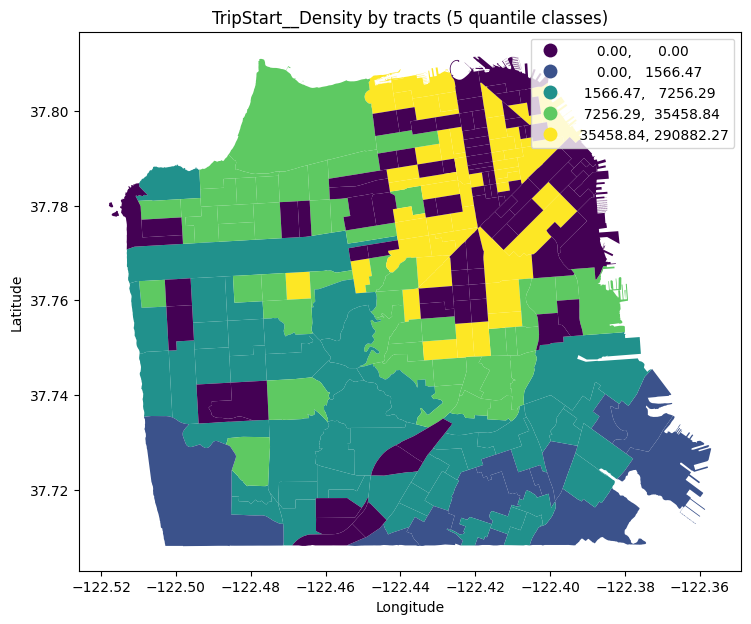

In [209]:
!pip install mapclassify>=2.4.0

import matplotlib.pyplot as plt
import mapclassify # Make sure to import the package after installation

# Assuming gdf_tracts is already defined and loaded as a GeoDataFrame

# Calculate quantiles for 5 classes
quantiles = gdf_tracts['TripStart_'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

# Create the plot using the calculated quantiles for classification
gdf_tracts.plot(column='TripStart_', cmap='viridis', scheme='User_Defined',
                classification_kwds={'bins': quantiles.tolist()[1:-1]},
                legend=True, figsize=(10, 7)) # scheme is used here
plt.title('TripStart__Density by tracts (5 quantile classes)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.legend(loc='upper left')

plt.show()

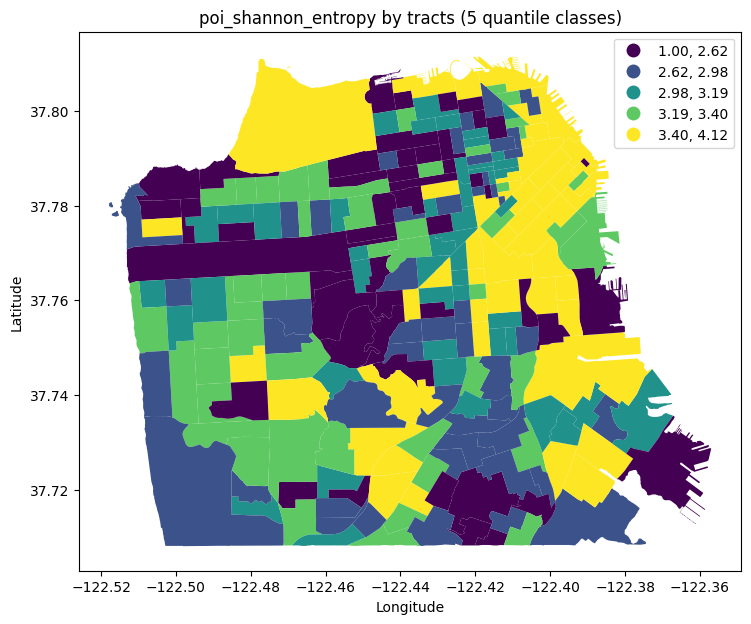

In [210]:
!pip install mapclassify>=2.4.0

import matplotlib.pyplot as plt
import mapclassify # Make sure to import the package after installation

# Assuming gdf_tracts is already defined and loaded as a GeoDataFrame

# Calculate quantiles for 5 classes
quantiles = gdf_tracts['poi_shanno'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

# Create the plot using the calculated quantiles for classification
gdf_tracts.plot(column='poi_shanno', cmap='viridis', scheme='User_Defined',
                classification_kwds={'bins': quantiles.tolist()[1:-1]},
                legend=True, figsize=(10, 7)) # scheme is used here
plt.title('poi_shannon_entropy by tracts (5 quantile classes)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

#### Viz and Export All Columns

In [189]:
import os
import pandas as pd
import geopandas as gpd
# numpy is not strictly needed here unless for other operations
import matplotlib.pyplot as plt
# mapclassify is used implicitly by scheme='Quantiles' but good to know it's there

# --- Configuration ---
# Assuming gdf_tracts is your loaded GeoDataFrame
# Example: gdf_tracts = gpd.read_file('your_shapefile.shp')
output_dir = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot'
num_classes = 5 # Number of quantile classes
plot_figsize = (12, 8) # Figure size
plot_dpi = 150 # Resolution for saved JPG

# --- Preparation ---
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get the name of the geometry column (more robust than assuming 'geometry')
geom_col_name = gdf_tracts.geometry.name

# --- Iteration and Visualization ---
print(f"Starting visualization process. Output directory: {output_dir}")

for column in gdf_tracts.columns:
    # 1. Skip the geometry column itself
    if column == geom_col_name:
        print(f"\nSkipping geometry column: '{column}'")
        continue

    print(f"\nProcessing column: '{column}'...")

    try:
        # 2. Attempt conversion to numeric, coercing errors
        #    Using .copy() to avoid SettingWithCopyWarning if gdf_tracts is a slice
        numeric_series = pd.to_numeric(gdf_tracts[column], errors='coerce').copy()

        # 3. Check if the result is suitable for plotting
        if not pd.api.types.is_numeric_dtype(numeric_series):
            print(f"-> Column '{column}' is not numeric after conversion. Skipping.")
            continue

        if numeric_series.isnull().all():
            print(f"-> Column '{column}' contains only NaN values after conversion. Skipping.")
            continue

        # Check for sufficient unique values for classification (Quantiles need at least k unique values)
        unique_valid_count = numeric_series.nunique(dropna=True)
        if unique_valid_count < num_classes:
             print(f"-> Column '{column}' has only {unique_valid_count} unique non-NaN value(s). "
                   f"Cannot create {num_classes} quantile classes. Skipping.")
             # Optional: Could adjust k here: k_actual = max(1, unique_valid_count)
             # Or use a different scheme like 'NaturalBreaks' which might be more flexible
             continue

        # Check if the GeoDataFrame geometry itself is valid (basic check)
        if gdf_tracts.geometry.is_empty.all() or not gdf_tracts.geometry.is_valid.all():
             print(f"-> Warning: GeoDataFrame contains empty or invalid geometries. Plotting might fail or look incorrect.")
             # Consider cleaning gdf_tracts beforehand if this is the case:
             # gdf_tracts = gdf_tracts[~gdf_tracts.geometry.is_empty]
             # gdf_tracts = gdf_tracts[gdf_tracts.geometry.is_valid]


        # --- Plotting ---
        fig, ax = plt.subplots(1, 1, figsize=plot_figsize)

        # Define how to represent missing values (NaNs) in the plot
        missing_kwds = {
            "color": "lightgrey",
            "edgecolor": "black",
            "hatch": "///",
            "label": "Missing/Invalid Data",
        }

        # Use the Quantiles scheme - often more robust than User_Defined with manual bins
        # Plot the original gdf_tracts but use the converted numeric_series for the 'column' argument
        gdf_tracts.plot(column=numeric_series,   # Use the validated numeric data
                        ax=ax,
                        cmap='viridis',          # Colormap
                        scheme='Quantiles',      # Classification scheme
                        k=num_classes,           # Number of classes
                        legend=True,
                        legend_kwds={            # Customize legend
                            'title': f"{column}\n(Quantiles)",
                            'loc': 'upper left',
                            'fmt': "{:.2f}"      # Format legend numbers (adjust as needed)
                        },
                        missing_kwds=missing_kwds # Specify how to draw NaNs
                       )

        ax.set_title(f'{column} by Census Tract ({num_classes} Quantile Classes)')
        # You might want to turn off axis labels/ticks for cleaner maps
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_xlabel('Longitude') # Often omitted for choropleth maps
        # ax.set_ylabel('Latitude')  # Often omitted for choropleth maps


        # --- Saving ---
        # Sanitize column name for filename (replace spaces, slashes etc.) - basic example
        safe_col_name = "".join(c if c.isalnum() else "_" for c in column)
        output_filename = f"{safe_col_name}_quantiles_map.jpg"
        output_path = os.path.join(output_dir, output_filename)

        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(output_path, dpi=plot_dpi, bbox_inches='tight')
        print(f"-> Plot saved successfully to: {output_path}")


    except Exception as e:
        # Print specific error for the problematic column
        print(f"-> ERROR visualizing column '{column}': {e}")
        # This includes the original 'aspect must be finite and positive' error

    finally:
        # --- Cleanup ---
        # Ensure the plot is closed even if errors occurred, preventing memory leaks
        # and display issues in interactive environments (like Jupyter)
        if 'fig' in locals() and plt.fignum_exists(fig.number):
             plt.close(fig)


print("\nFinished processing all columns.")

Starting visualization process. Output directory: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot

Processing column: 'Tract_ID'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Tract_ID_quantiles_map.jpg

Processing column: 'crash_coun'...


/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/crash_coun_quantiles_map.jpg

Processing column: 'Area_km2'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Area_km2_quantiles_map.jpg

Processing column: 'Population'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Population_quantiles_map.jpg

Processing column: 'Building_d'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Building_d_quantiles_map.jpg

Processing column: 'Felony_den'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Felony_den_quantiles_map.jpg

Processing column: 'Misdemeano'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Misdemeano_quantiles_map.jpg

Processing column: 'Violation.'...
-> Plot saved successfully to: /

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Commercial_quantiles_map.jpg

Processing column: 'Industrial'...


/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Industrial_quantiles_map.jpg

Processing column: 'Residentia'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Residentia_quantiles_map.jpg

Processing column: 'Mixed.Use'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Mixed_Use_quantiles_map.jpg

Processing column: 'commerci_1'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/commerci_1_quantiles_map.jpg

Processing column: 'tree_densi'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/tree_densi_quantiles_map.jpg

Processing column: 'open_space'...


/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/open_space_quantiles_map.jpg

Processing column: 'intersecti'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/intersecti_quantiles_map.jpg

Processing column: 'road_densi'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/road_densi_quantiles_map.jpg

Processing column: 'traffic_si'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/traffic_si_quantiles_map.jpg

Processing column: 'parking_me'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/parking_me_quantiles_map.jpg

Processing column: 'Bus.Stop.D'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Bus_Stop_D_quantiles_map.jpg

Processing column: 'Bus.Line.D'...
-> Plot saved successfully t

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Metro_Stop_quantiles_map.jpg

Processing column: 'Metro.Line'...


/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Metro_Line_quantiles_map.jpg

Processing column: 'SVI'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/SVI_quantiles_map.jpg

Processing column: 'GVI'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/GVI_quantiles_map.jpg

Processing column: 'VEI'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/VEI_quantiles_map.jpg

Processing column: 'VMI'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/VMI_quantiles_map.jpg

Processing column: 'VHI'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/VHI_quantiles_map.jpg

Processing column: 'avg_speed_'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/a

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Native_Ame_quantiles_map.jpg

Processing column: 'Unemployme'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Unemployme_quantiles_map.jpg

Processing column: 'Ethics_div'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/Ethics_div_quantiles_map.jpg

Processing column: 'MedHHInc'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/MedHHInc_quantiles_map.jpg

Processing column: 'MedRent'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/MedRent_quantiles_map.jpg

Processing column: 'MedHVal'...
-> Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./X Var Plot/MedHVal_quantiles_map.jpg

Processing column: 'Tract'...
-> Plot saved successfully to: /content/drive/MyD

In [ ]:
# prompt: 将gdf_tracts的所有columns转为float，并分别进行可视化，并另存为 jpg (path =  '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/)

import matplotlib.pyplot as plt

# Assuming gdf_tracts is already loaded and processed as in your provided code.

# Define the output path
output_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/'

# Iterate through columns, excluding 'geometry' and 'Tract_ID'
for column in gdf_tracts.columns:
  if column not in ['geometry', 'Tract_ID']:
    try:
      # Convert column to numeric, coercing errors to NaN
      gdf_tracts[column] = pd.to_numeric(gdf_tracts[column], errors='coerce')

      # Create the plot
      fig, ax = plt.subplots(1, 1, figsize=(10, 7))
      gdf_tracts.plot(column=column, cmap='viridis', legend=True, ax=ax)
      plt.title(f'{column} by Tract')
      plt.xlabel('Longitude')
      plt.ylabel('Latitude')

      # Save the plot as a JPG file
      plt.savefig(f"{output_path}{column}.jpg")
      plt.close(fig) # Close the figure to free memory

      print(f"Plot for column '{column}' saved as {output_path}{column}.jpg")

    except Exception as e:
      print(f"Error processing column '{column}': {e}")


Plot for column 'crash_coun' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/crash_coun.jpg
Plot for column 'Area_km2' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Area_km2.jpg
Plot for column 'Population' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Population.jpg
Plot for column 'Building_d' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Building_d.jpg
Plot for column 'Felony_den' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Felony_den.jpg
Plot for column 'Misdemeano' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Misdemeano.jpg
Plot for column 'Violation.' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Violation..jpg
Plot for column 'Homeless_d' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Homeless_d.jpg
Plot for column 'Public' saved as /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/Public.jpg
Plot

In [211]:
# Save the GeoDataFrame to a shapefile

output_shapefile_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250503.shp'
try:
    gdf_tracts.to_file(output_shapefile_path)
    print(f"GeoDataFrame saved to: {output_shapefile_path}")
except Exception as e:
    print(f"An error occurred while saving the shapefile: {e}")


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075980501 of field Tract of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075980501 of field geoid of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075017102 of field Tract of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075017102 of field geoid of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075012302 of field Tract of f

GeoDataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250503.shp


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075047903 of field geoid of feature 201 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075016102 of field geoid of feature 202 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075012801 of field geoid of feature 203 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075010402 of field geoid of feature 204 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 6075061101 of field ge

#### Viz GVI Points

In [ ]:
# prompt: 读取一个shape file (file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts.shp')

# Assuming file_path is defined as in your provided code.
file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/SF_SVI_segmentation.shp'

try:
    gdf_SVI_pt = gpd.read_file(file_path)
    print('done')
except FileNotFoundError:
    print(f"Error: Shapefile not found at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred while reading the shapefile: {e}")

gdf_SVI_pt.head()

done


,pid,lat,lon,heading,pitch,roll,year,month,season,road,sidewalk,building,wall,fence,pole,traffic li,traffic si,vegetation,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle,geometry
0,h-lNuBxBmiXjTtMh_kZ0Gg,37.8,-122.5,252.6,92.7,4.1,2018,3,spring,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-122.48385 37.78776)
1,27FBkF_2eLT8UkqunyL5Qg,37.8,-122.5,71.9,86.6,356.0,2019,6,summer,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-122.4838 37.78774)
2,HRBefceyqxf2y1qWQhIhLw,37.8,-122.5,73.2,86.6,356.2,2020,1,winter,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-122.48381 37.78774)
3,AQhS_kV8N9sWek_VxPu2Rg,37.8,-122.5,73.4,86.1,356.4,2021,3,spring,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-122.48386 37.78773)
4,uMhyf0WFNnNz86k3ph5Bjg,37.8,-122.5,72.9,86.1,356.0,2022,5,spring,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-122.48383 37.78773)


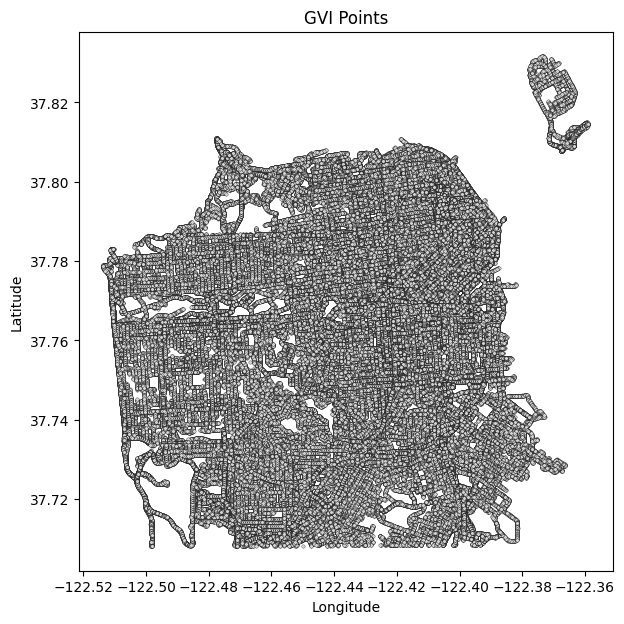

In [ ]:
# prompt: 可视化gdf_SVI_pt，仅仅画出每个点即可，每个点有细的灰色边框线，要有横纵坐标轴，不需要可视化columns, 并另存为 jpg (path =  '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/)

import matplotlib.pyplot as plt

# Assuming gdf_SVI_pt is already loaded as a GeoDataFrame

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
gdf_SVI_pt.plot(ax=ax, markersize=6, edgecolor='black', linewidth=0.2, color='lightgray')  # Adjust markersize as needed
plt.title('GVI Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Define the output path
output_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./JPG/'
plt.savefig(f"{output_path}gdf_SVI_pt.jpg")
plt.show()


#4 - VIF Analysis

In [7]:
# prompt: 读取一个shape file (file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts.shp')


# Assuming file_path is defined as in your provided code.
file_path  = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts 250503.shp'

try:
    gdf_tracts = gpd.read_file(file_path)
    print(gdf_tracts.shape)
    print(gdf_tracts.columns)

except FileNotFoundError:
    print(f"Error: Shapefile not found at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred while reading the shapefile: {e}")

df_cleaned = gdf_tracts

df_cleaned = df_cleaned[df_cleaned['TripStart_'] != 0]
print(df_cleaned.shape)


(240, 74)
Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Building_d',
       'Felony_den', 'Misdemeano', 'Violation.', 'Homeless_d', 'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'commerci_1',
       'tree_densi', 'open_space', 'intersecti', 'road_densi', 'traffic_si',
       'parking_me', 'Bus.Stop.D', 'Bus.Line.D', 'Metro.Stop', 'Metro.Line',
       'SVI', 'GVI', 'VEI', 'VMI', 'VHI', 'avg_speed_', 'Whites', 'Black',
       'Asian', 'Native_Ame', 'Unemployme', 'Ethics_div', 'MedHHInc',
       'MedRent', 'MedHVal', 'Tract', 'TripStart', 'TripEnd', 'geoid',
       'SVI_road', 'SVI_sidewa', 'SVI_buildi', 'SVI_wall', 'SVI_fence',
       'SVI_pole', 'SVI_traffi', 'SVI_traf_1', 'SVI_vegeta', 'SVI_terrai',
       'SVI_sky', 'SVI_person', 'SVI_rider', 'SVI_car', 'SVI_truck', 'SVI_bus',
       'SVI_train', 'SVI_motorc', 'SVI_bicycl', 'Gini_Simps', 'poi_shanno',
       'SVI_Obstac', 'SVI_Walkab', 'SVI_Furnit', 'SVI_Enclos', 'TransitSto',
       'crash_den'

### Standardization for VIF

In [8]:
# Standardization to df_cleaned

import numpy as np
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:.4f}'.format

# Assuming df_cleaned is your DataFrame
# Select only numeric columns for standardization
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')  # 强制转为数值型，非法值变成 NaN


numeric_cols = df_cleaned.select_dtypes(include=np.number).columns

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the numeric columns
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Drop rows with any NaN values in df_cleaned


df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
Tract_ID,156.0000,0.0000,1.0032,-0.2723,-0.2337,-0.1842,-0.1477,5.4858
crash_coun,156.0000,0.0000,1.0032,-0.8641,-0.2941,-0.2941,-0.0091,8.5403
Area_km2,156.0000,-0.0000,1.0032,-0.7095,-0.4101,-0.2694,0.0028,6.7551
Population,156.0000,0.0000,1.0032,-1.1795,-0.4985,-0.1557,0.1767,8.7513
Building_d,156.0000,-0.0000,1.0032,-2.9057,-0.4722,0.0224,0.5951,2.4374
Felony_den,156.0000,0.0000,1.0032,-0.6464,-0.4275,-0.2747,0.1139,8.2085
Misdemeano,156.0000,0.0000,1.0032,-0.5948,-0.4288,-0.3005,0.0328,9.5105
Violation.,156.0000,-0.0000,1.0032,-0.3662,-0.2782,-0.1981,-0.0597,11.1216
Homeless_d,156.0000,-0.0000,1.0032,-0.4489,-0.4101,-0.3508,-0.1376,7.2168
Public,156.0000,-0.0000,1.0032,-0.7549,-0.6027,-0.3657,0.3713,4.3849


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# df_cleaned=gdf_tracts
# Separate X and Y
X = df_cleaned.drop(columns=['TripStart','TripEnd', 'TripStart_', 'TripEnd_de', 'geometry',  'Public',
       'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'crash_coun','Area_km2', 'Tract_ID'])
X = X.apply(pd.to_numeric, errors='coerce')  # 强制转为数值型，非法值变成 NaN

# Instead of dropping all columns with ANY NaNs, drop only rows with NaNs:
X = X.dropna(axis=0, how='any')  # 去掉还有 NaN 的行

y_new = df_cleaned['TripStart_'][X.index]  # Align y_new with X's index

# Calculate VIF
pd.options.display.float_format = '{:.1f}'.format
vif_data_new = pd.DataFrame()
vif_data_new["Variable"] = X.columns
vif_data_new["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# vif_data_new

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


### Correlation Matrix

In [218]:
# prompt: X = df_cleaned.drop(columns=['TripStart','TripEnd', 'TripStart_', 'TripEnd_de', 'geometry',  'Public',
#        'Commercial', 'Industrial', 'Residentia', 'Mixed.Use', 'crash_coun','Area_km2', 'Tract_ID'])
# X = X.apply(pd.to_numeric, errors='coerce')  # 强制转为数值型，非法值变成 NaN
# 生成X 的 Correlation Matrix，并可视化

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X is already defined as in your provided code
# ... (your existing code to define X) ...

# Generate the correlation matrix
correlation_matrix = X.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(22, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Remove Features with high VIF

In [10]:

variables_to_remove = [

    # --------- Demo ---------
    # 'Population',
    # 'Whites',
    # 'Black',
    # 'Asian',
    'Native_Ame',
    # 'Ethics_div',
    # 'MedHHInc',
    'MedRent',
    'MedHVal',

    # 'Felony_den',
    'Misdemeano',
    'Violation.',
    # 'Homeless_d',
    'Unemployme',

    # --------- 5D Density ---------
    'Building_d',
    'commerci_1',
    # 'intersecti',
    #  'road_densi',


    # --------- 5D Diversity ---------
    # 'Gini_Simps',
    # 'poi_shanno',
    'Public',
    'Commercial',
    'Industrial',
    'Residentia',
    'Mixed.Use',

    # --------- 5D Design ---------
    'tree_densi',
    'open_space',
    'traffic_si',
    # 'parking_me',
    'avg_speed_',

    # --------- 5D Transit + Accessibility---------
    'Bus.Stop.D',
    'Bus.Line.D',
    'Metro.Stop',
    'Metro.Line',
    # 'TransitSto',

    # --------- SVI ---------
    # 'SVI_Obstac',
    # 'SVI_Furnit',
    # 'SVI_Enclos',
    # 'SVI_vegeta',
    'SVI_person',
    # 'SVI_Walkab',

    'SVI_sidewa',
    'SVI',
    'GVI',
    'VEI',
    'VMI',
    'VHI',
    'SVI_road',
    'SVI_buildi',
    'SVI_wall',
    'SVI_fence',
    'SVI_pole',
    'SVI_traffi',
    'SVI_traf_1',
    'SVI_terrai',
    'SVI_sky',
    'SVI_person',
    'SVI_rider',
    'SVI_car',
    'SVI_truck',
    'SVI_bus',
    'SVI_train',
    'SVI_motorc',
    'SVI_bicycl',

    # --------- OTHER---------
    'Tract',
    'geoid',
    'crash_den'
]

In [11]:
#  删除 high VIF columns
df_cleaned1 = df_cleaned.drop(columns=variables_to_remove)

df_cleaned=df_cleaned1
# Separate X and Y
X = df_cleaned.drop(columns=['TripStart','TripEnd', 'TripStart_', 'TripEnd_de', 'geometry',  'crash_coun','Area_km2', 'Tract_ID'])
X = X.apply(pd.to_numeric, errors='coerce')  # 强制转为数值型，非法值变成 NaN

# Instead of dropping all columns with ANY NaNs, drop only rows with NaNs:
X = X.dropna(axis=0, how='any')  # 去掉还有 NaN 的行

y_new = df_cleaned['TripStart_'][X.index]  # Align y_new with X's index


In [12]:
# Calculate VIF
pd.options.display.float_format = '{:.1f}'.format
vif_data_new = pd.DataFrame()
vif_data_new["Variable"] = X.columns
vif_data_new["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data_new)

      Variable  VIF
0   Population  3.6
1   Felony_den  6.8
2   Homeless_d  2.4
3   intersecti  6.1
4   road_densi  3.5
5   parking_me  5.0
6       Whites 11.1
7        Black  2.7
8        Asian  7.9
9   Ethics_div  2.3
10    MedHHInc  3.6
11  SVI_vegeta  2.5
12  Gini_Simps  1.9
13  poi_shanno  1.4
14  SVI_Obstac  1.9
15  SVI_Walkab  2.0
16  SVI_Furnit  1.9
17  SVI_Enclos  4.7
18  TransitSto  2.9


In [295]:
#  对原数据集 - 删除 high VIF columns
df_cleaned = gdf_tracts.drop(columns=variables_to_remove)
print(df_cleaned.shape)
df_cleaned.describe().T

(240, 27)


,count,mean,std,min,25%,50%,75%,max
crash_coun,240.0,3.7,3.1,1.0,2.0,3.0,4.0,34.0
Area_km2,240.0,0.5,0.7,0.0,0.2,0.3,0.5,6.0
Population,240.0,38148.4,31819.4,8.6,21258.5,31181.3,44410.4,301895.5
Felony_den,240.0,663.5,948.8,2.3,181.3,337.9,735.4,6175.7
Homeless_d,240.0,525.6,1108.2,2.7,44.8,128.3,393.8,9457.5
intersecti,240.0,509.1,267.8,39.9,349.0,465.4,594.5,1958.0
road_densi,240.0,31.9,8.5,7.4,27.0,31.0,36.1,59.7
parking_me,240.0,1843.8,2658.1,0.0,0.0,498.5,2324.0,11013.8
Whites,240.0,43.2,20.5,0.0,28.1,43.7,59.3,85.9
Black,240.0,5.1,7.2,0.0,1.1,2.8,6.2,50.9


### Save Shapefile / After VIF

In [296]:
# Save the GeoDataFrame to a shapefile

output_shapefile_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts VIF 250503.shp'

try:
    df_cleaned.to_file(output_shapefile_path)
    print(f"GeoDataFrame saved to: {output_shapefile_path}")
except Exception as e:
    print(f"An error occurred while saving the shapefile: {e}")

GeoDataFrame saved to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts VIF 250503.shp


In [17]:
desc_transposed = X.describe().T
desc_transposed

,count,mean,std,min,25%,50%,75%,max
Population,156.0,0.0,1.0,-1.2,-0.5,-0.2,0.2,8.8
Felony_den,156.0,0.0,1.0,-0.6,-0.4,-0.3,0.1,8.2
Homeless_d,156.0,-0.0,1.0,-0.4,-0.4,-0.4,-0.1,7.2
intersecti,156.0,0.0,1.0,-1.8,-0.6,-0.1,0.4,4.5
road_densi,156.0,-0.0,1.0,-2.9,-0.6,-0.1,0.5,3.2
parking_me,156.0,0.0,1.0,-0.5,-0.5,-0.4,-0.1,3.9
Whites,156.0,-0.0,1.0,-2.1,-0.8,-0.0,0.8,1.8
Black,156.0,0.0,1.0,-0.7,-0.5,-0.3,0.1,6.1
Asian,156.0,0.0,1.0,-1.7,-0.9,-0.1,0.7,3.4
Ethics_div,156.0,-0.0,1.0,-5.3,-0.6,0.2,0.6,2.0


,Variable Name,VIF
0,Population,3.6
1,Felony_den,6.8
2,Homeless_d,2.4
3,intersecti,6.1
4,road_densi,3.5
5,parking_me,5.0
6,Whites,11.1
7,Black,2.7
8,Asian,7.9
9,Ethics_div,2.3


In [28]:
# Assuming X and vif_data_new are already defined as in your provided code.
# ... (your existing code to define X and vif_data_new) ...

variable_mapping = {
    'intersecti': 'Intersection Density',
    'road_densi': 'Road Density',
    'Gini_Simps': 'Gini Simpson Index',
    'poi_shanno': 'POI Shanno Entropy ',
    'parking_me': 'Parking Meter Density',
    'TransitSto': 'Transit Stop Density',
    'SVI_Enclos': 'Visual Enclosure',
    'SVI_Walkab': 'Visual Walkability',
    'SVI_vegeta': 'Visual Vegetation',
    'SVI_Furnit': 'Visual Furniture',
    'Population': 'Population Density',
    'Whites': 'Whites %',
    'Black': 'Black %',
    'Asian': 'Asian %',
    'Ethics_div': 'Ethnic Diversity',
    'MedHHInc': 'Median Household Income',
    'Felony_den': 'Felony Density',
    'Homeless_d': 'Homeless Density',
}

# Merge the two dataframes
df_description = pd.merge(X.describe().T, vif_data_new, left_index=True, right_on='Variable Name', how='left')

# Rename columns and reorder rows
df_description = df_description.rename(columns={'Variable': 'Variable Name'})

#Create a new column 'Variable Name' based on the mapping
df_description['Variable Name'] = df_description['Variable Name'].map(variable_mapping).fillna(df_description['Variable Name'])

ordered_variables = list(variable_mapping.values())
missing_variables = set(ordered_variables) - set(df_description['Variable Name'])

# Add missing variables with NaN values
for var in missing_variables:
    df_description = pd.concat([
        df_description,
        pd.DataFrame({'Variable Name': [var], **{col: np.nan for col in df_description.columns if col != 'Variable Name'}}),
    ], ignore_index=True)


df_description = df_description.set_index('Variable Name').loc[ordered_variables].reset_index()

df_description


,Variable Name,count,mean,std,min,25%,50%,75%,max,VIF
0,Intersection Density,156.0,476.6,241.4,39.9,330.9,450.5,562.5,1567.2,6.1
1,Road Density,156.0,31.0,8.2,7.4,26.3,30.4,35.0,57.1,3.5
2,Gini Simpson Index,156.0,0.3,0.2,0.0,0.2,0.4,0.5,0.7,1.9
3,POI Shanno Entropy,156.0,2.9,0.5,1.0,2.6,3.0,3.3,4.1,1.4
4,Parking Meter Density,156.0,1132.5,2110.4,0.0,0.0,267.4,1003.6,9342.3,5.0
5,Transit Stop Density,156.0,95.4,58.1,9.9,58.7,85.3,114.6,329.3,2.9
6,Visual Enclosure,156.0,0.2,0.1,0.0,0.2,0.2,0.3,0.8,4.7
7,Visual Walkability,156.0,0.1,0.0,0.0,0.0,0.1,0.1,0.1,2.0
8,Visual Vegetation,156.0,0.1,0.0,0.0,0.0,0.1,0.1,0.2,2.5
9,Visual Furniture,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9


In [30]:
X = df_cleaned.drop(columns=['Tract_ID', 'geometry', 'crash_coun','Area_km2', 'TripEnd_de', 'TripStart', 'TripEnd','TripStart_'])
print(X.shape)
print(vif_data_new.shape)
X.describe().T

(156, 19)
(19, 2)


,count,mean,std,min,25%,50%,75%,max
Population,156.0,35865.3,30496.7,8.6,20712.8,31132.1,41237.1,301895.5
Felony_den,156.0,453.0,699.4,2.3,154.9,261.5,532.4,6175.7
Homeless_d,156.0,326.7,724.0,2.7,30.7,73.5,227.4,5535.1
intersecti,156.0,476.6,241.4,39.9,330.9,450.5,562.5,1567.2
road_densi,156.0,31.0,8.2,7.4,26.3,30.4,35.0,57.1
parking_me,156.0,1132.5,2110.4,0.0,0.0,267.4,1003.6,9342.3
Whites,156.0,42.3,20.5,0.0,25.9,41.8,58.6,79.6
Black,156.0,5.3,7.5,0.0,1.2,2.8,6.3,50.9
Asian,156.0,33.9,19.8,0.0,16.7,31.3,47.2,100.0
Ethics_div,156.0,0.6,0.1,0.0,0.5,0.6,0.7,0.8


# 5 - Model

### Load Shapefile / After VIF

In [4]:

file_path = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./Shapefile/GVI Tracts VIF 250503.shp'

import geopandas as gpd
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
    gdf_tracts = gpd.read_file(file_path)
    print(gdf_tracts.shape)
    print(gdf_tracts.columns)

except FileNotFoundError:
    print(f"Error: Shapefile not found at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred while reading the shapefile: {e}")

df_cleaned=gdf_tracts

df_cleaned = df_cleaned[df_cleaned['TripStart_'] != 0]
print(df_cleaned.shape)

# df_cleaned.head()

(240, 27)
Index(['Tract_ID', 'crash_coun', 'Area_km2', 'Population', 'Felony_den',
       'Homeless_d', 'intersecti', 'road_densi', 'parking_me', 'Whites',
       'Black', 'Asian', 'Ethics_div', 'MedHHInc', 'TripStart', 'TripEnd',
       'SVI_vegeta', 'Gini_Simps', 'poi_shanno', 'SVI_Obstac', 'SVI_Walkab',
       'SVI_Furnit', 'SVI_Enclos', 'TransitSto', 'TripStart_', 'TripEnd_de',
       'geometry'],
      dtype='object')
(156, 27)


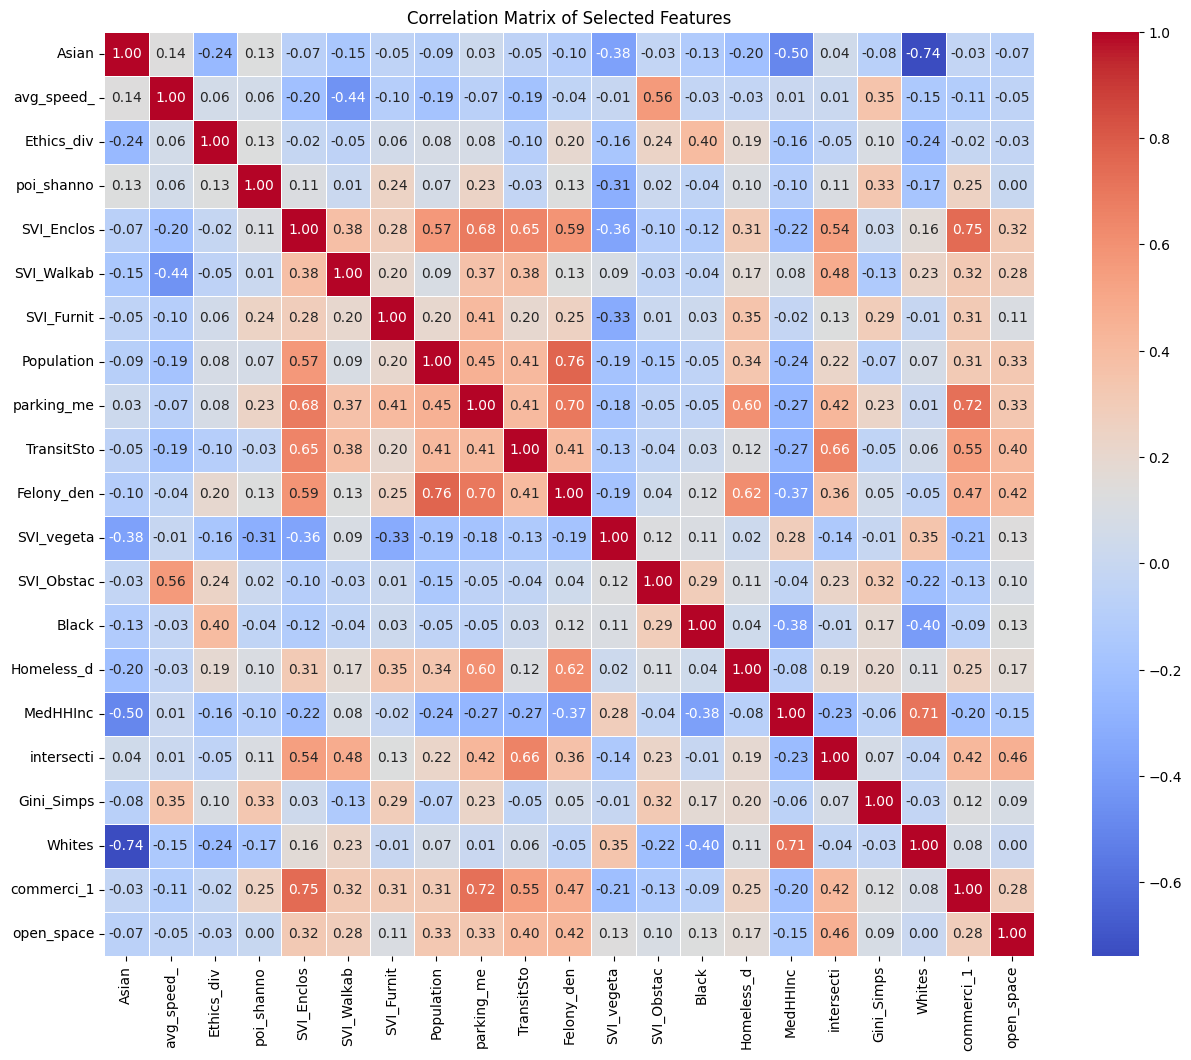


--- Identifying High Correlations (Absolute Value >= 0.7) Involving ['Population', 'Felony_den', 'Homeless_d', 'commerci_1', 'open_space', 'intersecti', 'parking_me', 'avg_speed_', 'Whites', 'Black', 'Asian', 'Ethics_div', 'MedHHInc', 'SVI_vegeta', 'Gini_Simps', 'poi_shanno', 'SVI_Obstac', 'SVI_Walkab', 'SVI_Furnit', 'SVI_Enclos', 'TransitSto'] ---
Found the following high correlations:
- Population and Felony_den: Correlation = 0.765
  Suggestion: Evaluate if one of 'Population' or 'Felony_den' is redundant. Consider removing the one that is less interpretable, has lower data quality, or is less central to your theoretical model.
- commerci_1 and SVI_Enclos: Correlation = 0.745
  Suggestion: Evaluate if one of 'commerci_1' or 'SVI_Enclos' is redundant. Consider removing the one that is less interpretable, has lower data quality, or is less central to your theoretical model.
- commerci_1 and parking_me: Correlation = 0.723
  Suggestion: Evaluate if one of 'commerci_1' or 'parking_me' 

<ipython-input-245-69dbf406d892>:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='correlation', y='pair_label', data=df_high_corr.sort_values(by='abs_correlation', ascending=False),


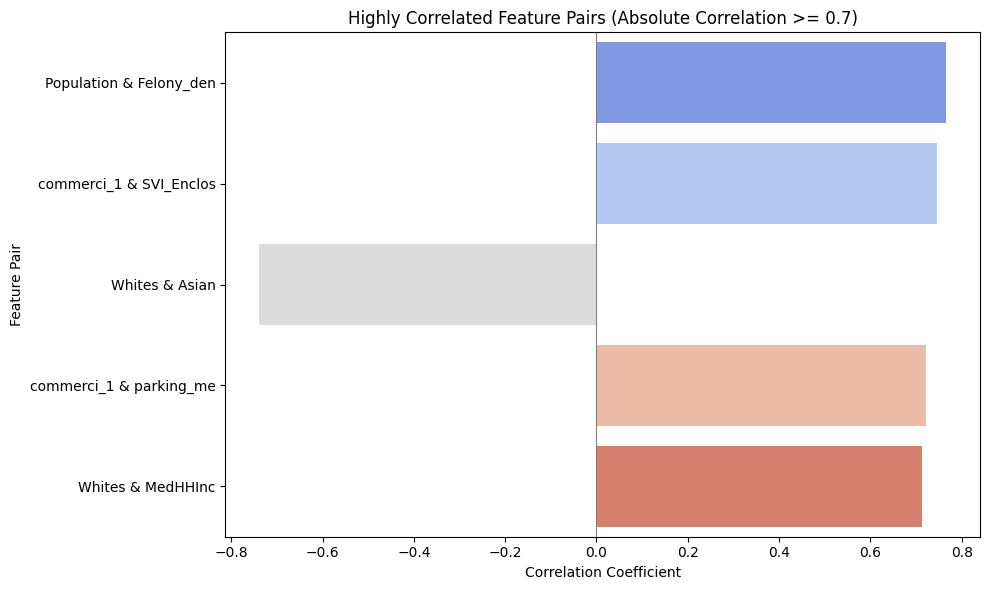

In [245]:
# !pip install seaborn
import seaborn as sns # Import the seaborn library for heatmap visualization

X = df_cleaned.drop(columns=['Tract_ID', 'geometry', 'crash_coun','Area_km2','TripStart_', 'TripEnd_de', 'TripStart', 'TripEnd'])
X = X.apply(pd.to_numeric, errors='coerce')
# Drop rows with NaNs, keeping columns with valid data
X = X.dropna(axis=0, how='any')  # axis=0 for rows, how='any' for any NaN in row

# Re-align y_log with X after dropping rows
y_log = np.log1p(df_cleaned.loc[X.index, 'TripStart_'])  # log(1 + y), using X.index

df=X
# --- 2. Define Features for Analysis ---
target_features = X.columns.tolist()
related_features = X.columns.tolist()
# You can add more features from your DataFrame to related_features if needed
# features_to_analyze = target_features + related_features
# Or, analyze correlation among *all* numeric features if desired:
# features_to_analyze = df.select_dtypes(include=np.number).columns.tolist()

# Let's analyze the target features against the specified related ones, plus themselves
features_to_analyze = list(set(target_features + related_features))

# Check if all specified columns exist in the DataFrame
missing_cols = [col for col in features_to_analyze if col not in df.columns]
if missing_cols:
    print(f"Error: The following columns are missing from the DataFrame: {missing_cols}")
    # Handle error appropriately, e.g., raise ValueError or exit
    exit() # Or raise ValueError(...)

# Select the subset of the DataFrame for correlation analysis
df_subset = df[features_to_analyze]

# --- 3. Calculate Correlation Matrix ---
# Use 'pearson' for linear correlation (common default)
# Use 'spearman' for rank correlation (monotonic, less sensitive to outliers)
correlation_matrix = df_subset.corr(method='pearson')

# print("--- Correlation Matrix ---")
# print(correlation_matrix)

# --- 4. Visualize the Correlation Matrix (Recommended) ---
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # Now sns is defined
plt.title('Correlation Matrix of Selected Features')
plt.show()

# --- 5. Identify Highly Correlated Pairs Involving Target Features ---
        # Define your threshold for "high" correlation (e.g., 0.7 or 0.8)
threshold = 0.7

print(f"\n--- Identifying High Correlations (Absolute Value >= {threshold}) Involving {target_features} ---")

high_correlation_info = []

# Iterate through the correlation matrix
for col1 in target_features:
    # Check correlations of this target feature against all others in the analyzed set
    for col2 in features_to_analyze:
        # Skip self-correlation
        if col1 == col2:
            continue

        # Get the correlation value
        corr_value = correlation_matrix.loc[col1, col2]

        # Check if absolute correlation meets the threshold
        if abs(corr_value) >= threshold:
            # Store the pair (ensure consistent order) and the value
            # Avoid duplicates by sorting the pair names
            pair = tuple(sorted((col1, col2)))
            info = {'pair': pair, 'feature1': col1, 'feature2': col2, 'correlation': corr_value}

            # Add to list only if this specific pair hasn't been added
            is_duplicate = False
            for existing_info in high_correlation_info:
                if existing_info['pair'] == pair:
                    is_duplicate = True
                    break
            if not is_duplicate:
                high_correlation_info.append(info)

# --- 6. Print Findings and Suggestions ---
if not high_correlation_info:
    print(f"No high correlations (>= {threshold}) found involving {target_features} among the analyzed features.")
else:
    print("Found the following high correlations:")
    for info in high_correlation_info:
        f1, f2, corr = info['feature1'], info['feature2'], info['correlation']
        print(f"- {f1} and {f2}: Correlation = {corr:.3f}")

        # Provide specific suggestions based on the pair
        pair_sorted = info['pair']
        if pair_sorted == tuple(sorted(('SVI_Enclos', 'Building_d'))):
            print("  Suggestion: SVI_Enclos and Building_d are highly correlated. Consider removing SVI_Enclos, as it might be a visual proxy for Building_d (which might be a more direct measure of density).")
        elif pair_sorted == tuple(sorted(('commerci_1', 'Commercial'))):
            print("  Suggestion: commerci_1 (POI density) and Commercial (Land Use %) seem highly correlated. They might capture similar aspects of commercial intensity. Consider keeping the one that aligns better with your hypothesis or is easier to interpret (e.g., keep Commercial if focusing on broad land use, or commerci_1 if focusing on specific POI count).")
        # Add more elif conditions here for other specific pairs you anticipate
        else:
            # General suggestion for other pairs
            print(f"  Suggestion: Evaluate if one of '{f1}' or '{f2}' is redundant. Consider removing the one that is less interpretable, has lower data quality, or is less central to your theoretical model.")

# --- 6. Process, Visualize, and Print Findings ---

# Check if any high correlations were found
if not high_correlation_info:
    print(f"No high correlations (Absolute Value >= {threshold}) found involving the specified features.")
else:
    # --- 6a. Convert findings to a DataFrame ---
    df_high_corr = pd.DataFrame(high_correlation_info)

    # Optional: Ensure unique pairs (though the loop logic tries to handle this)
    # df_high_corr = df_high_corr.drop_duplicates(subset=['pair'])

    # Select and reorder columns for clarity
    df_high_corr = df_high_corr[['feature1', 'feature2', 'correlation']].copy()

    # Sort by absolute correlation value for better visualization
    df_high_corr['abs_correlation'] = df_high_corr['correlation'].abs()
    df_high_corr = df_high_corr.sort_values(by='abs_correlation', ascending=False)

    # --- 6b. Print Findings as a Table ---
    print("\n--- Highly Correlated Feature Pairs (Table) ---")
    # Use to_string() for potentially better alignment than default print
    print(df_high_corr[['feature1', 'feature2', 'correlation']].to_string(index=False))

    # --- 6c. Visualize Findings as a Bar Chart ---
    print("\n--- Highly Correlated Feature Pairs (Bar Chart) ---")
    plt.figure(figsize=(10, max(6, len(df_high_corr) * 0.4))) # Adjust figure size based on number of pairs

    # Create labels for the bars (y-axis)
    df_high_corr['pair_label'] = df_high_corr['feature1'] + ' & ' + df_high_corr['feature2']

    # Create the horizontal bar plot
    # Using the original correlation value for bar height shows direction (+/-)
    # Sorting ensures the most correlated pairs are at the top (if ascending=False in sort_values)
    # or bottom (if ascending=True). Let's plot with highest abs corr at the top.
    sns.barplot(x='correlation', y='pair_label', data=df_high_corr.sort_values(by='abs_correlation', ascending=False),
                palette='coolwarm', orient='h') # Using coolwarm: red for positive, blue for negative

    plt.title(f'Highly Correlated Feature Pairs (Absolute Correlation >= {threshold})')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Feature Pair')
    plt.axvline(x=0, color='grey', linewidth=0.8) # Add a line at x=0 for reference
    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    plt.show()


### Random Forest

#### Non Standardization


Random Forest Performance:
R-squared: 0.825854723042244
Mean Squared Error: 0.3655699078781011
Mean Absolute Error: 0.44372470417282267


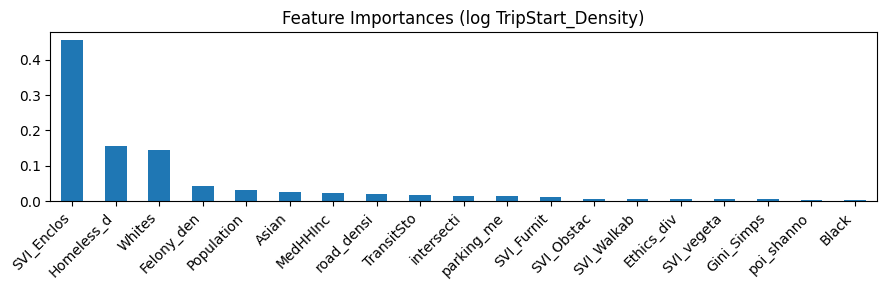

In [298]:
# Random Forest
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# Define X and log-transformed y
# Instead of dropping columns with ANY NaNs after conversion, drop only ROWS with NaNs
X = df_cleaned.drop(columns=['Tract_ID', 'geometry', 'crash_coun','Area_km2','TripStart_', 'TripEnd_de', 'TripStart', 'TripEnd'])
X = X.apply(pd.to_numeric, errors='coerce')
# Drop rows with NaNs, keeping columns with valid data
X = X.dropna(axis=0, how='any')  # axis=0 for rows, how='any' for any NaN in row

# Re-align y_log with X after dropping rows
y_log = np.log1p(df_cleaned.loc[X.index, 'TripStart_'])  # log(1 + y), using X.index


X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train, y_train)
y_pred_log = rf_log.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred_log)
mse = mean_squared_error(y_test, y_pred_log)
mae = mean_absolute_error(y_test, y_pred_log)

print(f"Random Forest Performance:")
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")



# Feature importances
importances_log = pd.Series(rf_log.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(9, 3))
importances_log.plot(kind='bar', title='Feature Importances (log TripStart_Density)')
plt.xticks(rotation=45, ha='right') # Rotate labels
plt.tight_layout()
plt.show()

####  Standardization


In [50]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# import matplotlib.pyplot as plt

# # Assume df_cleaned is your DataFrame loaded previously
# # df_cleaned = pd.read_csv(...) # Or however you load your data

# # --- 1. Define Features (X) and Target (y) ---
# # Select feature columns BEFORE any scaling or splitting
# feature_cols_to_drop = ['Tract_ID', 'geometry', 'crash_coun','Area_km2','TripStart_', 'TripEnd_de', 'TripStart', 'TripEnd']


# # Ensure target column 'TripStart_' is not in the drop list
# # (It's the target, so it's handled separately)

# all_cols = df_cleaned.columns
# potential_feature_cols = [col for col in all_cols if col not in feature_cols_to_drop and col != 'TripStart_']

# # Create X from potential feature columns, converting to numeric robustly
# # It's generally better to ensure numeric conversion happened earlier
# # or select only known numeric columns here.
# X = df_cleaned[potential_feature_cols].apply(pd.to_numeric, errors='coerce')

# # Define target variable y and apply log transform
# if 'TripStart_' in df_cleaned.columns:
#     y_numeric = pd.to_numeric(df_cleaned['TripStart_'], errors='coerce')
#     y_log = np.log1p(y_numeric) # log(1 + y)
# else:
#     raise ValueError("Target column 'TripStart_' not found in DataFrame.")

# # --- 2. Handle Missing Values (NaNs) ---
# # Drop rows with NaNs in features (X) or target (y_log) BEFORE splitting
# combined = pd.concat([X, y_log], axis=1).dropna(axis=0, how='any')
# X = combined[X.columns]
# y_log = combined[y_log.name] # Retrieve the aligned target Series

# print(f"Shape of X after NaN handling: {X.shape}")
# print(f"Shape of y_log after NaN handling: {y_log.shape}")
# if X.empty or y_log.empty:
#      raise ValueError("No data remaining after handling NaNs. Check data quality or NaN handling strategy.")


# # --- 3. Split Data into Training and Testing sets ---
# # Split the *original* (unscaled) data
# X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# print(f"\nShape of X_train before scaling: {X_train.shape}")
# print(f"Shape of X_test before scaling: {X_test.shape}")

# # --- 4. Standardize Features ---
# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler ONLY on the training data features
# # The scaler learns the mean and std dev from X_train
# scaler.fit(X_train)

# # Transform both the training and testing data features
# # using the *same* fitted scaler
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Optional: Convert scaled arrays back to DataFrames to keep column names
# # This is useful for feature importance plotting later
# X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# print("\nStandardization applied successfully.")
# print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
# print(f"Shape of X_test_scaled: {X_test_scaled.shape}")


# # --- 5. Train Random Forest Model ---
# # Initialize the model
# rf_log = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the model using the SCALED training data
# rf_log.fit(X_train_scaled, y_train)
# print("\nRandom Forest model trained on standardized data.")

# # --- 6. Predict on Scaled Test Data ---
# y_pred_log = rf_log.predict(X_test_scaled)

# # --- 7. Evaluate the Model ---
# r2 = r2_score(y_test, y_pred_log)
# mse = mean_squared_error(y_test, y_pred_log)
# mae = mean_absolute_error(y_test, y_pred_log)

# print("\nRandom Forest Performance (Standardized Data):")
# print(f"R-squared: {r2}")
# print(f"Mean Squared Error: {mse}")
# print(f"Mean Absolute Error: {mae}")

# # --- 8. Feature Importances ---
# # Get importances from the trained model
# # The index should match the columns of the data used for training (X_train_scaled)
# importances_log = pd.Series(rf_log.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# # Plot feature importances
# plt.figure(figsize=(9, 3)) # Adjusted size
# importances_log.plot(kind='bar', title='Feature Importances (Log Crash_density Density - Standardized Data)')
# plt.ylabel('Importance')
# plt.xticks(rotation=45, ha='right') # Rotate labels
# plt.tight_layout()
# plt.show()


In [ ]:
# Create a DataFrame from the feature importances
importances_df = pd.DataFrame({'Feature': importances_log.index, 'Importance': importances_log.values})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# importances_df


#### SHAP

In [299]:
X.columns

Index(['Population', 'Felony_den', 'Homeless_d', 'intersecti', 'road_densi',
       'parking_me', 'Whites', 'Black', 'Asian', 'Ethics_div', 'MedHHInc',
       'SVI_vegeta', 'Gini_Simps', 'poi_shanno', 'SVI_Obstac', 'SVI_Walkab',
       'SVI_Furnit', 'SVI_Enclos', 'TransitSto'],
      dtype='object')

Renamed columns in X_test copy for plotting.

Calculating SHAP values...
SHAP values calculated.

Generating SHAP summary plot...


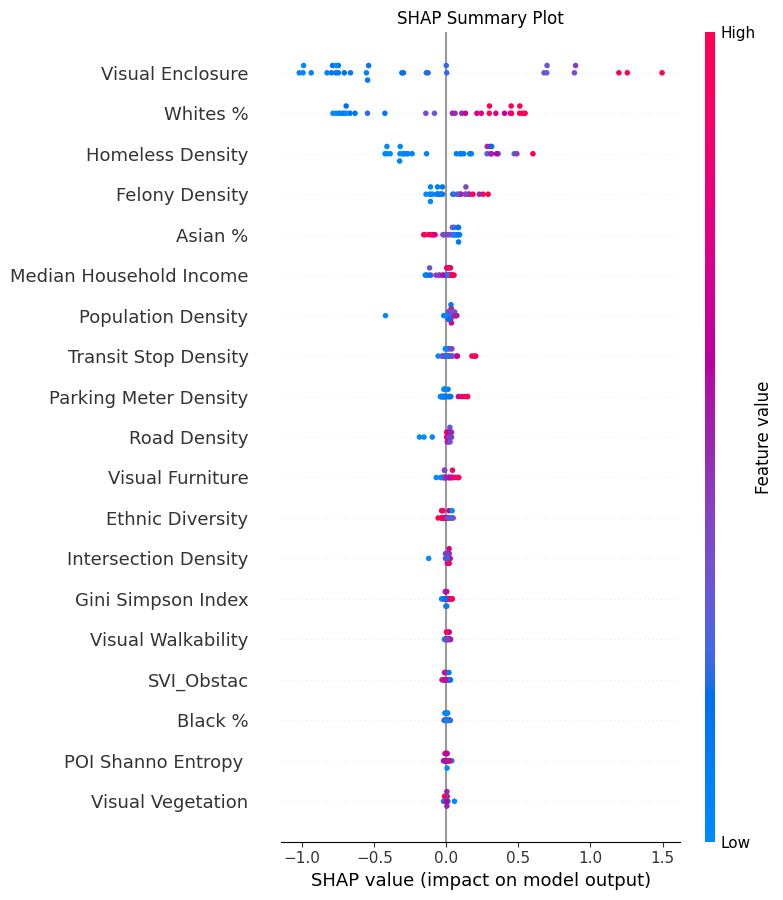

Summary plot generated.


In [300]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Assuming numpy is needed elsewhere

# --- Define Feature Name Mapping (Reordered based on image_79e14a.png) ---
feature_name_mapping = {

    # Built Environment - Density & Diversity
    # 'Building_d': 'Building Density',
    # 'commerci_1': 'POI Density',
    'intersecti': 'Intersection Density',
    'road_densi': 'Road Density',


    # Built Environment - Diversity
    'Gini_Simps': 'Gini Simpson Index',
    'poi_shanno': 'POI Shanno Entropy ',

    # Built Environment - Design
    # 'mean_eleva': 'Elevation',
    # 'mean_slope': 'Street Slope',
    # 'avg_speed_': 'Avg. Speed Limit',
    'parking_me': 'Parking Meter Density',

    # Transit
    'TransitSto': 'Transit Stop Density', # Assuming this maps correctly

    # Visual Metrics (SVI)
    'SVI_Enclos': 'Visual Enclosure',
    'SVI_Walkab': 'Visual Walkability', # Assuming SVI_Walkab exists
    # 'VMI': 'Visual Motorization',    # Assuming VMI exists
    'SVI_vegeta': 'Visual Vegetation',
    # 'SVI_Obstac': 'Visual Obstacle', # Note: Typo in image 'Obstacale' kept for consistency
    'SVI_Furnit': 'Visual Furniture',

    # Socio-Demographics
    'Population': 'Population Density',
    'Whites': 'Whites %',
    'Black': 'Black %',
    'Asian': 'Asian %',
    'Ethics_div': 'Ethnic Diversity',
    'MedHHInc': 'Median Household Income',
    'Felony_den': 'Felony Density',
    'Homeless_d': 'Homeless Density',
}

# --- Ensure X_test is a pandas DataFrame ---
if not isinstance(X_test, pd.DataFrame):
    # If X_test is numpy, try to convert it using known feature names
    # This assumes 'original_feature_names_from_data' was defined correctly earlier
    try:
        # Make sure original_feature_names_from_data is defined from previous context
        # If not, you might need to get it from rf_log.feature_names_in_ if available
        if 'original_feature_names_from_data' not in locals() and hasattr(rf_log, 'feature_names_in_'):
             original_feature_names_from_data = rf_log.feature_names_in_
        elif 'original_feature_names_from_data' not in locals():
             raise NameError("Original feature names needed to convert X_test to DataFrame.")

        if X_test.shape[1] == len(original_feature_names_from_data):
            X_test = pd.DataFrame(X_test, columns=original_feature_names_from_data)
            print("Converted X_test from NumPy array to DataFrame.")
        else:
            raise ValueError("Shape mismatch between X_test and feature names.")
    except Exception as e:
        print(f"Error: X_test must be a pandas DataFrame for renaming. Conversion failed: {e}")
        # Handle error appropriately, maybe exit
        # For now, we'll proceed but the plot names might be incorrect
        X_test_renamed = X_test # Use original X_test, plot names will be wrong

else:
    # --- Create a copy of X_test to rename columns ---
    X_test_renamed = X_test.copy()

    # --- Rename columns in the copy ---
    # Only rename columns that exist in both X_test and the mapping
    cols_to_rename = {
        orig_name: new_name
        for orig_name, new_name in feature_name_mapping.items()
        if orig_name in X_test_renamed.columns
    }
    X_test_renamed.rename(columns=cols_to_rename, inplace=True)
    print("Renamed columns in X_test copy for plotting.")
    # print("New column names:", X_test_renamed.columns.tolist()) # Optional: verify

# --- Calculate SHAP values ---
try:
    print("\nCalculating SHAP values...")
    explainer = shap.TreeExplainer(rf_log)
    # Use the original X_test for calculating SHAP values
    shap_values = explainer.shap_values(X_test)
    print("SHAP values calculated.")

    # --- Generate Summary Plot with Renamed Features ---
    print("\nGenerating SHAP summary plot...")
    plt.figure() # Optional: Create a figure context if needed
    shap.summary_plot(
        shap_values,
        features=X_test_renamed, # Use the DataFrame with RENAMED columns here
        feature_names=X_test_renamed.columns, # Explicitly pass renamed columns
        show=False # Prevent immediate display if further customization is needed
    )
    # Add title or other customizations if desired
    plt.title("SHAP Summary Plot")
    plt.tight_layout() # Adjust layout
    plt.show() # Display the plot
    print("Summary plot generated.")

except Exception as e:
    print(f"\nAn error occurred during SHAP calculation or plotting: {e}")
    import traceback
    traceback.print_exc()

#####  Dependence Plots each variable

Generating SHAP Dependence Plots (X-Numbered Labels & Filenames, Updated Visual Style, Dynamic Y-Axis)...

Processing feature (X1): 'intersecti' (Displaying as: 'Intersection Density')
  SHAP value range: 0.1482
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X1_Intersection_Density_shap_dependence_styled.jpg


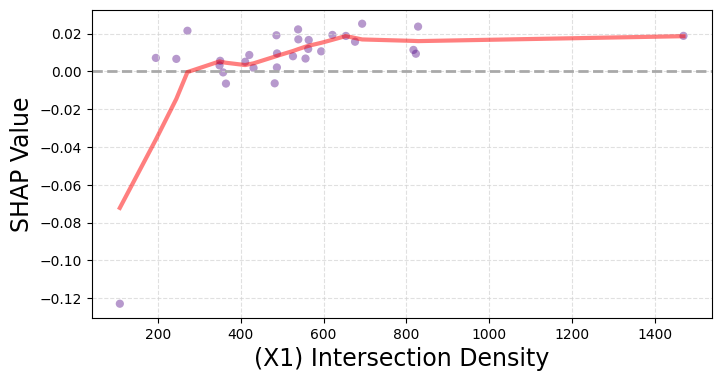


Processing feature (X2): 'road_densi' (Displaying as: 'Road Density')
  SHAP value range: 0.2235
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X2_Road_Density_shap_dependence_styled.jpg


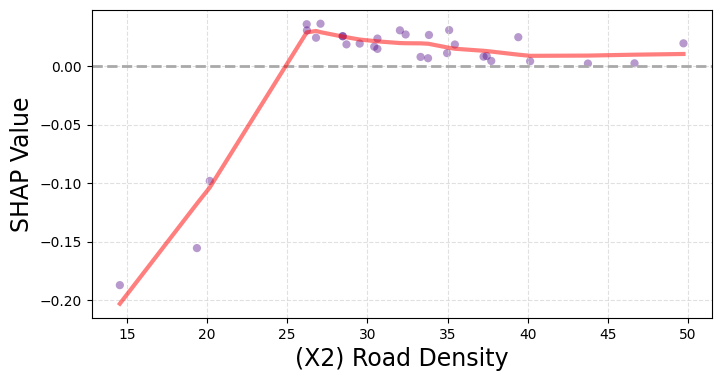


Processing feature (X3): 'Gini_Simps' (Displaying as: 'Gini Simpson Index')
  SHAP value range: 0.0741
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X3_Gini_Simpson_Index_shap_dependence_styled.jpg


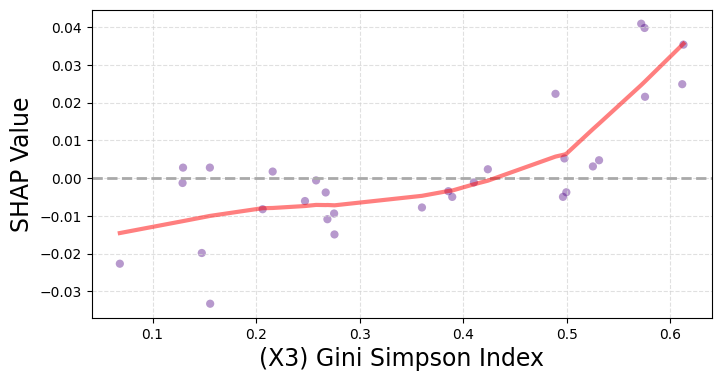


Processing feature (X4): 'poi_shanno' (Displaying as: 'POI Shanno Entropy ')
  SHAP value range: 0.0579
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X4_POI_Shanno_Entropy_shap_dependence_styled.jpg


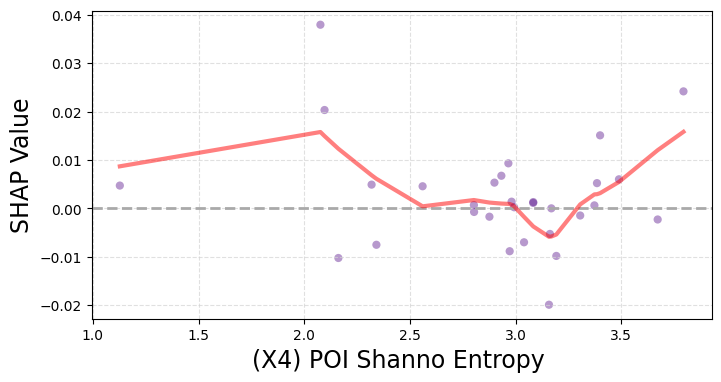


Processing feature (X5): 'parking_me' (Displaying as: 'Parking Meter Density')
  SHAP value range: 0.1890
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X5_Parking_Meter_Density_shap_dependence_styled.jpg


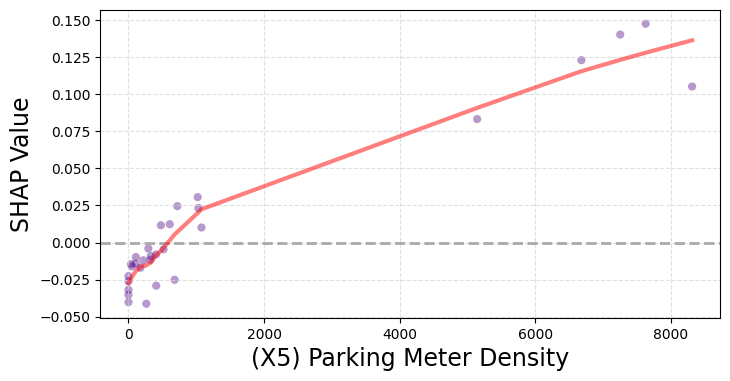


Processing feature (X6): 'TransitSto' (Displaying as: 'Transit Stop Density')
  SHAP value range: 0.2607
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X6_Transit_Stop_Density_shap_dependence_styled.jpg


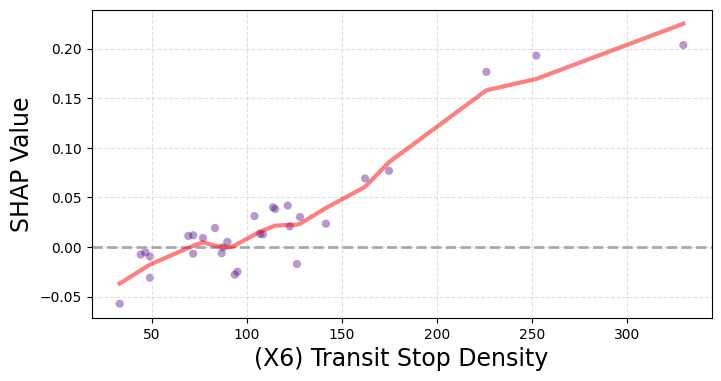


Processing feature (X7): 'SVI_Enclos' (Displaying as: 'Visual Enclosure')
  SHAP value range: 2.5180
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X7_Visual_Enclosure_shap_dependence_styled.jpg


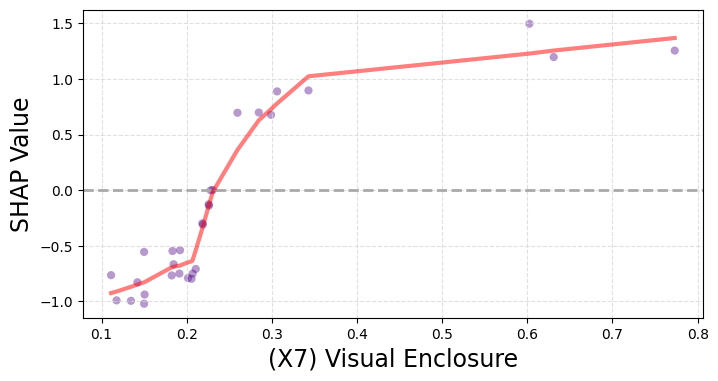


Processing feature (X8): 'SVI_Walkab' (Displaying as: 'Visual Walkability')
  SHAP value range: 0.0415
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X8_Visual_Walkability_shap_dependence_styled.jpg


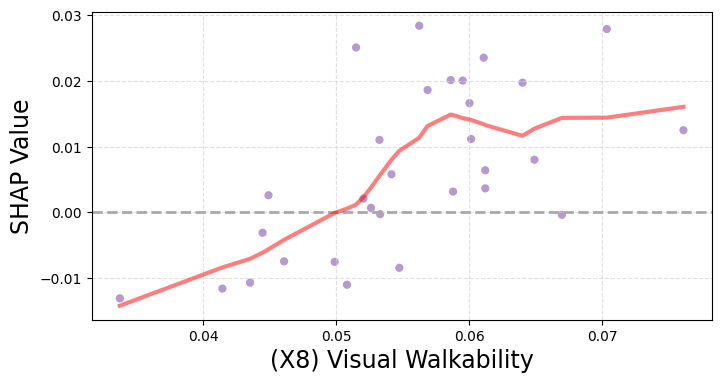


Processing feature (X9): 'SVI_vegeta' (Displaying as: 'Visual Vegetation')
  SHAP value range: 0.0759
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X9_Visual_Vegetation_shap_dependence_styled.jpg


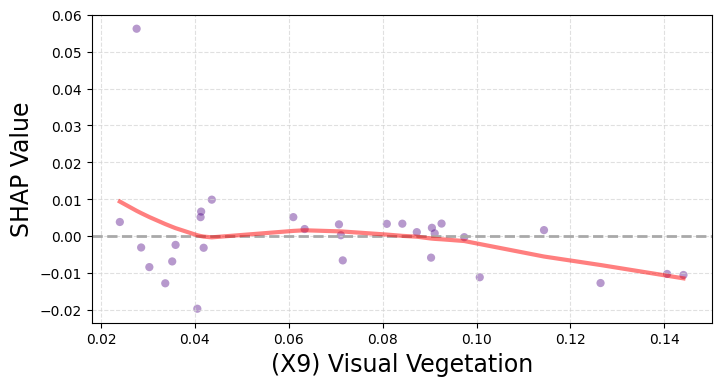


Processing feature (X10): 'SVI_Furnit' (Displaying as: 'Visual Furniture')
  SHAP value range: 0.1568
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X10_Visual_Furniture_shap_dependence_styled.jpg


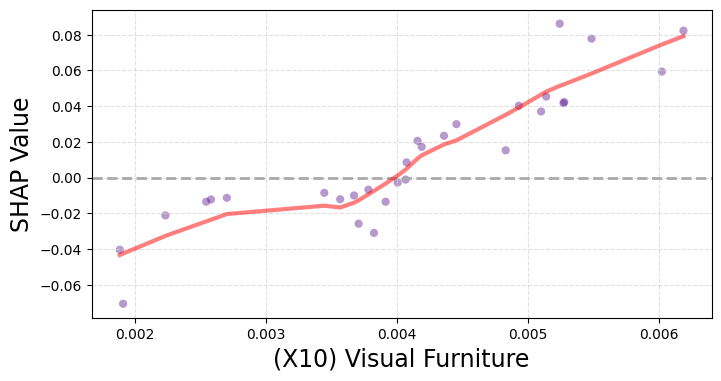


Processing feature (X11): 'Population' (Displaying as: 'Population Density')
  SHAP value range: 0.4950
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X11_Population_Density_shap_dependence_styled.jpg


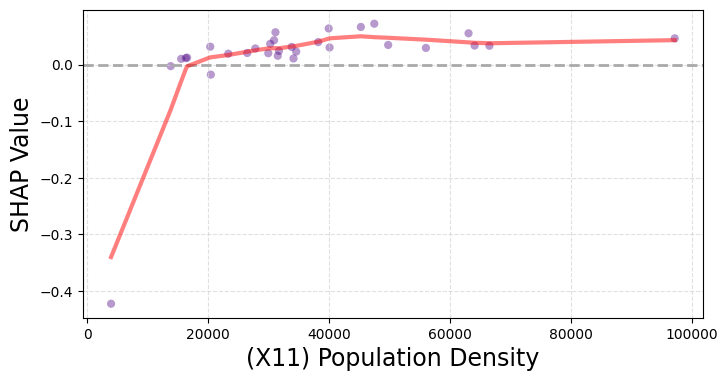


Processing feature (X12): 'Whites' (Displaying as: 'Whites %')
  SHAP value range: 1.3341
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X12_Whites___shap_dependence_styled.jpg


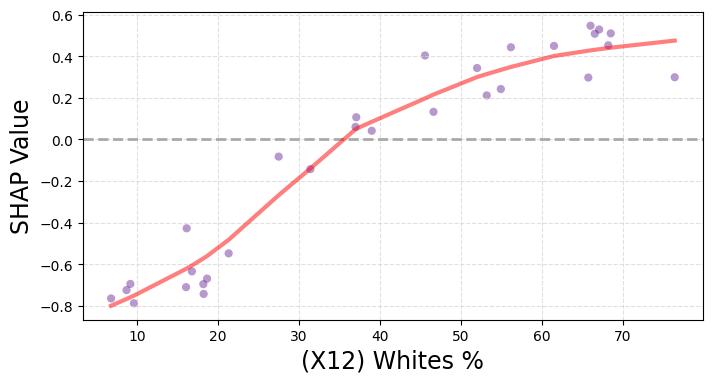


Processing feature (X13): 'Black' (Displaying as: 'Black %')
  SHAP value range: 0.0431
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X13_Black___shap_dependence_styled.jpg


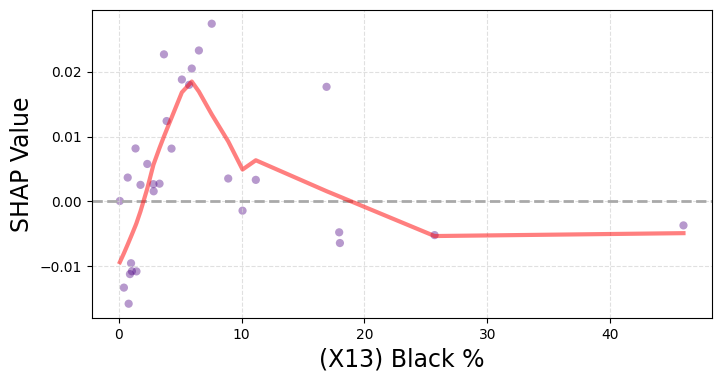


Processing feature (X14): 'Asian' (Displaying as: 'Asian %')
  SHAP value range: 0.2499
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X14_Asian___shap_dependence_styled.jpg


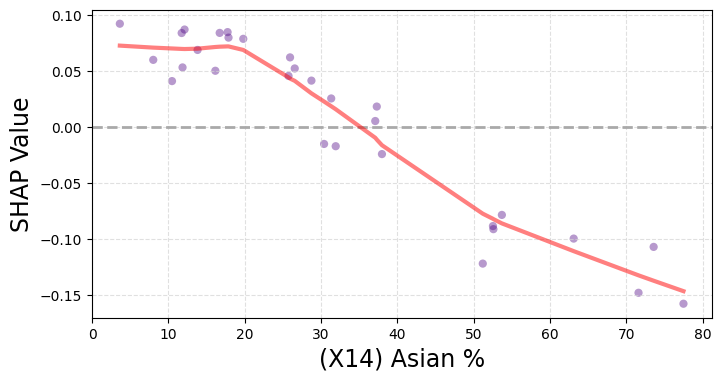


Processing feature (X15): 'Ethics_div' (Displaying as: 'Ethnic Diversity')
  SHAP value range: 0.1043
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X15_Ethnic_Diversity_shap_dependence_styled.jpg


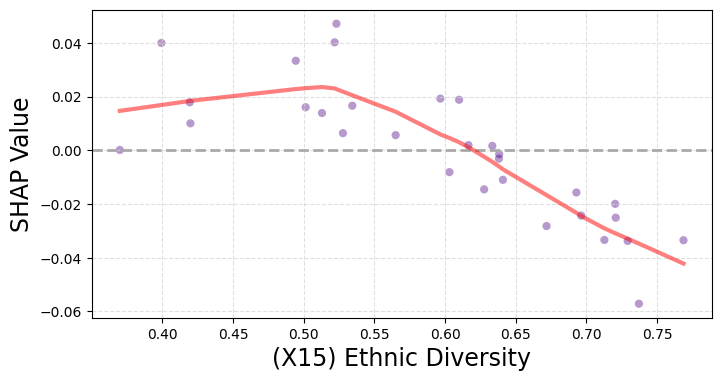


Processing feature (X16): 'MedHHInc' (Displaying as: 'Median Household Income')
  SHAP value range: 0.2003
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X16_Median_Household_Income_shap_dependence_styled.jpg


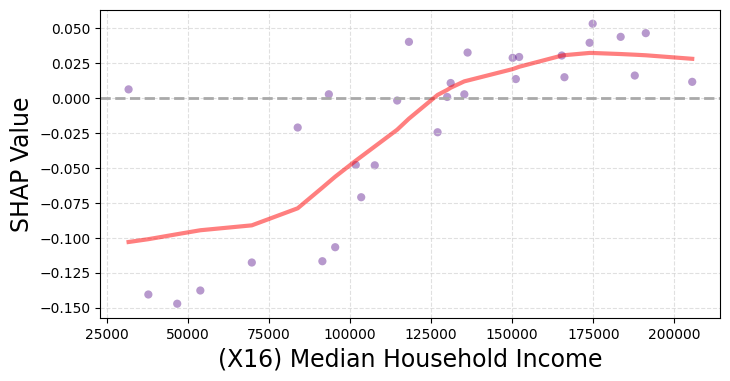


Processing feature (X17): 'Felony_den' (Displaying as: 'Felony Density')
  SHAP value range: 0.4310
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X17_Felony_Density_shap_dependence_styled.jpg


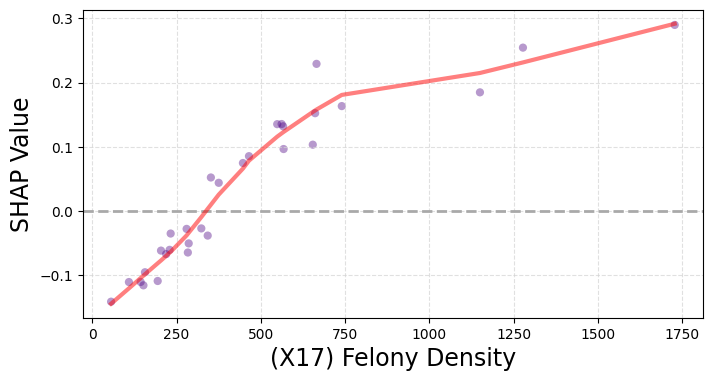


Processing feature (X18): 'Homeless_d' (Displaying as: 'Homeless Density')
  SHAP value range: 1.0262
  Success: Plot saved successfully to: /content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/X18_Homeless_Density_shap_dependence_styled.jpg


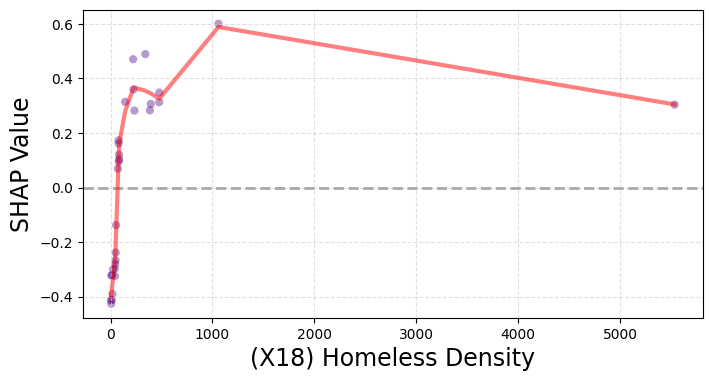


Finished generating all plots.


In [301]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm # Used for lowess
import os # Ensure os module is imported
import traceback # For detailed error printing (if needed)
import string # Keep for potential fallback, though not primary use now


output_dir = '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/'


# Create an ordered list of original names based on the desired order
ordered_original_names = list(feature_name_mapping.keys())


print("Generating SHAP Dependence Plots (X-Numbered Labels & Filenames, Updated Visual Style, Dynamic Y-Axis)...")

# --- Prepare Data (Feature Names, SHAP Array, Features Data) ---
# Get original feature names from X_test if possible, used for indexing SHAP values
original_feature_names_from_data = None
if isinstance(X_test, pd.DataFrame):
    original_feature_names_from_data = X_test.columns.tolist()
elif hasattr(shap_values, 'feature_names') and shap_values.feature_names is not None:
     original_feature_names_from_data = shap_values.feature_names # Fallback

if original_feature_names_from_data is None:
     try:
         num_features = X_test.shape[1]
         original_feature_names_from_data = [f"Feature {i}" for i in range(num_features)]
         print(f"Warning: Could not reliably retrieve original feature names from data. Using generic names: {original_feature_names_from_data}")
     except Exception as e:
         print(f"Error: Could not determine original feature names from data. Cannot proceed without them. {e}")
         # Exit or raise error if feature names are crucial and cannot be determined
         # For now, we'll try to continue but might fail later
         original_feature_names_from_data = list(feature_name_mapping.keys()) # Risky assumption


# Prepare shap_values array and features_data consistently
if hasattr(shap_values, 'values'): # Standard output from explainer(X_test)
    shap_values_array = shap_values.values
    if hasattr(shap_values, 'data') and isinstance(shap_values.data, pd.DataFrame):
         features_data = shap_values.data
    elif isinstance(X_test, pd.DataFrame):
         features_data = X_test
    else:
         features_data = np.asarray(X_test)
elif isinstance(shap_values, np.ndarray): # Direct output from explainer.shap_values()
    shap_values_array = shap_values
    if isinstance(X_test, pd.DataFrame):
        features_data = X_test
    else:
        features_data = np.asarray(X_test)
else:
    raise TypeError("Unsupported type for shap_values.")

# Ensure features_data is DataFrame using original names if possible
if not isinstance(features_data, pd.DataFrame) and original_feature_names_from_data and features_data.shape[1] == len(original_feature_names_from_data):
    features_data = pd.DataFrame(features_data, columns=original_feature_names_from_data)
    print("Converted features_data to DataFrame using original names.")
elif not isinstance(features_data, pd.DataFrame):
     print("Warning: features_data is not a DataFrame. Indexing might rely on integer positions.")


# --- Loop Through Features based on the Reordered Mapping ---
# Use enumerate to get index for numbering, iterating through the defined order
for index, original_feature_name in enumerate(ordered_original_names):
    # Get the new feature name from the mapping
    new_feature_name = feature_name_mapping.get(original_feature_name)
    if new_feature_name is None:
        print(f"\nSkipping feature '{original_feature_name}': Not found in mapping dictionary.")
        continue # Skip if somehow the key isn't in the dict

    # --- Create the numbered prefix (X1, X2, ...) ---
    # *** Changed prefix format ***
    numbered_prefix_label = f"(X{index + 1})" # Format as (X1), (X2), ...
    numbered_prefix_filename = f"X{index + 1}" # Format as X1, X2, ... for filename


    print(f"\nProcessing feature {numbered_prefix_label}: '{original_feature_name}' (Displaying as: '{new_feature_name}')")

    fig = None # Initialize fig to None
    try:
        # --- 1. Get Data for the Current Feature using ORIGINAL name ---
        feature_values = None
        shap_values_for_feature = None
        feature_index = -1

        # Find the index in the original list derived from data
        try:
            feature_index = original_feature_names_from_data.index(original_feature_name)
        except ValueError:
            print(f"  Skipping plot: Original feature '{original_feature_name}' not found in the data's feature list.")
            continue
        except TypeError:
             print(f"  Skipping plot: Could not search for '{original_feature_name}' as original_feature_names_from_data is not a list.")
             continue


        # Get feature values from features_data (DataFrame or numpy)
        if isinstance(features_data, pd.DataFrame):
            if original_feature_name not in features_data.columns:
                print(f"  Skipping plot: Original feature '{original_feature_name}' not found in features_data columns.")
                continue
            feature_values = features_data[original_feature_name].values
        else: # Assuming numpy array
            if feature_index != -1 and feature_index < features_data.shape[1]:
                feature_values = features_data[:, feature_index]
            else:
                 print(f"  Skipping plot: Invalid index {feature_index} for numpy features_data.")
                 continue

        # Get SHAP values using the determined index
        if feature_index != -1:
            if shap_values_array.ndim == 2 and feature_index < shap_values_array.shape[1]:
                shap_values_for_feature = shap_values_array[:, feature_index]
            elif shap_values_array.ndim == 3 and feature_index < shap_values_array.shape[2]:
                print(f"  Warning: Using SHAP values from the first output/class for '{original_feature_name}'.")
                shap_values_for_feature = shap_values_array[:, 0, feature_index]
            else:
                print(f"  Skipping plot: Invalid shape for shap_values_array or index out of bounds for '{original_feature_name}'.")
                continue
        else:
             # Should have been caught earlier, but safety check
             continue

        # --- Calculate SHAP value range for dynamic Y-axis ---
        valid_shap_values = shap_values_for_feature[~np.isnan(shap_values_for_feature)]
        shap_range = 0
        if len(valid_shap_values) > 0:
            shap_range = np.ptp(valid_shap_values)
            print(f"  SHAP value range: {shap_range:.4f}")
        else:
            print(f"  Warning: No valid SHAP values found to determine range.")


        # --- 2. Create Figure and Axes ---
        fig, ax = plt.subplots(figsize=(8, 4))

        # --- 3. Plot Scatter Points ---
        ax.scatter(
            feature_values,
            shap_values_for_feature,
            color='indigo',
            edgecolors='none',
            alpha=0.4,
            s=35
        )

        # --- 4. Add y=0 Line ---
        ax.axhline(0, color='darkgrey', linestyle='--', linewidth=2)

        # --- 5. Plot LOWESS Curve ---
        mask = ~np.isnan(feature_values) & ~np.isnan(shap_values_for_feature)
        if np.sum(mask) >= 5:
            filtered_feature_values = feature_values[mask]
            filtered_shap_values = shap_values_for_feature[mask]
            try:
                lowess_results = sm.nonparametric.lowess(
                    filtered_shap_values, filtered_feature_values, frac=0.5, it=0
                )
                lowess_x = lowess_results[:, 0]
                lowess_y = lowess_results[:, 1]
                sort_order = np.argsort(lowess_x)
                ax.plot(lowess_x[sort_order], lowess_y[sort_order],
                        color='red', linestyle='-', alpha=0.5, linewidth=3)
            except Exception as lowess_e:
                print(f"  Warning: LOWESS calculation failed. Skipping curve. Error: {lowess_e}")
        else:
            print(f"  Skipping LOWESS curve: insufficient valid data points.")

        # --- 6. Add Grid ---
        ax.grid(True, linestyle='--', color='lightgrey', alpha=0.7)

        # --- 7. Set Axis Labels using NEW name and Numbered Prefix ---
        # *** Use (Xn) prefix for x-label ***
        ax.set_xlabel(f"{numbered_prefix_label} {new_feature_name}", fontsize=17) # Add space after prefix
        ax.set_ylabel(f"SHAP Value", fontsize=17)

        # # --- 8. Set Y-axis Limits Dynamically ---
        # if shap_range < 0.2 and len(valid_shap_values) > 0:
        #      ax.set_ylim(-0.08, 0.12)
        #      print("  Setting Y-axis limits to [-0.08, 0.12]")
        # else:
        #      ax.set_ylim(-0.8, 1)
        #      print("  Setting Y-axis limits to [-0.8,1]")

        # --- 9. Remove Title ---
        # ax.set_title(...)

        # --- 10. Remove Legend ---
        # No legend needed


        # Sanitize the NEW feature name
        safe_feature_name = "".join([c if c.isalnum() or c in (' ', '_', '-') else '_' for c in new_feature_name]).rstrip().replace(' ', '_')
        # Use the Xn prefix for filename
        output_filename = f"{numbered_prefix_filename}_{safe_feature_name}_shap_dependence_styled.jpg"
        output_filepath = os.path.join(output_dir, output_filename)

        save_success = False
        try:
            os.makedirs(output_dir, exist_ok=True)
            fig.savefig(output_filepath, bbox_inches='tight')
            save_success = True
            print(f"  Success: Plot saved successfully to: {output_filepath}")
        except Exception as e:
            print(f"  Error: Failed to save plot to {output_filepath}.")
            print(f"  Reason: {e}")

        # --- 12. Display Plot ---
        plt.show()

    except ValueError as ve:
         print(f"  Skipping plot for '{original_feature_name}': Feature might not be found or data issue. Error: {ve}")
    except Exception as e:
         print(f"  An unexpected error occurred during plot generation for '{original_feature_name}': {e}")
         print(traceback.format_exc())
    finally:
         # Ensure the figure is closed
         if fig is not None:
              plt.close(fig)
         else:
              plt.close()

print("\nFinished generating all plots.")


##### Merge plot

Found 8 JPG files to process in '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/3demo'.

Processing batch 1/1 (8 images)...
Target size for this batch set to: (727, 381) (from X11_Population_Density_shap_dependence_styled.jpg)
Resizing 'X12_Whites___shap_dependence_styled.jpg' from (712, 383) to (727, 381)
Resizing 'X13_Black___shap_dependence_styled.jpg' from (721, 381) to (727, 381)
Resizing 'X14_Asian___shap_dependence_styled.jpg' from (721, 381) to (727, 381)
Resizing 'X15_Ethnic_Diversity_shap_dependence_styled.jpg' from (721, 381) to (727, 381)
Resizing 'X16_Median_Household_Income_shap_dependence_styled.jpg' from (730, 381) to (727, 381)
Resizing 'X17_Felony_Density_shap_dependence_styled.jpg' from (712, 381) to (727, 381)
Resizing 'X18_Homeless_Density_shap_dependence_styled.jpg' from (712, 381) to (727, 381)


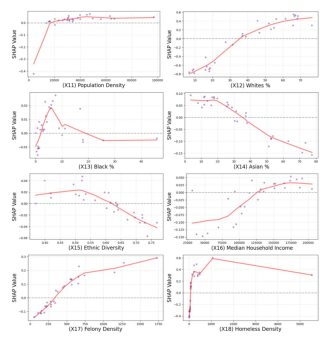

Combined image saved successfully to '/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/3demo/combined_0.jpg'


In [304]:
import os
from PIL import Image, UnidentifiedImageError # Import specific error
import math # For ceiling division

def combine_images_resized(image_dir, output_dir, rows=2, cols=3):

    try:
        # Filter for JPGs and exclude previously combined images
        all_files = os.listdir(image_dir)
        image_files = sorted([
            f for f in all_files
            if f.lower().endswith('.jpg') and not f.lower().startswith('combined_')
        ])
        print(f"Found {len(image_files)} JPG files to process in '{image_dir}'.")
    except FileNotFoundError:
        print(f"Error: Input directory not found: '{image_dir}'")
        return
    except Exception as e:
        print(f"Error reading image directory '{image_dir}': {e}")
        return

    if not image_files:
        print("No suitable JPG images found to process.")
        return

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    images_per_grid = rows * cols
    num_grids = math.ceil(len(image_files) / images_per_grid) # Calculate total grids needed

    for grid_index in range(num_grids):
        start_index = grid_index * images_per_grid
        end_index = start_index + images_per_grid
        batch_files = image_files[start_index:end_index]

        if not batch_files:
            continue # Should not happen with ceil, but safety check

        print(f"\nProcessing batch {grid_index + 1}/{num_grids} ({len(batch_files)} images)...")

        images_in_grid = []
        target_size = None
        first_image_path = os.path.join(image_dir, batch_files[0])

        # --- Determine target size from the first image ---
        try:
            with Image.open(first_image_path) as img:
                target_size = img.size
                print(f"Target size for this batch set to: {target_size} (from {batch_files[0]})")
        except (FileNotFoundError, UnidentifiedImageError, Exception) as e:
            print(f"Error opening first image '{batch_files[0]}' to determine size: {e}. Skipping batch.")
            continue # Skip this batch if target size cannot be determined

        # --- Load, resize (if needed), and collect images for the grid ---
        for filename in batch_files:
            image_path = os.path.join(image_dir, filename)
            try:
                with Image.open(image_path) as img:
                    # Ensure image is in RGB mode
                    img = img.convert('RGB')
                    if img.size != target_size:
                        print(f"Resizing '{filename}' from {img.size} to {target_size}")
                        # Use high-quality resampling filter
                        img = img.resize(target_size, Image.Resampling.LANCZOS)
                    images_in_grid.append(img.copy()) # Append a copy
            except (FileNotFoundError, UnidentifiedImageError, Exception) as e:
                print(f"Warning: Error processing image '{filename}': {e}. Skipping this image.")
                # Optionally add a blank placeholder here if strict grid filling is needed
                # images_in_grid.append(Image.new('RGB', target_size, 'lightgrey')) # Example placeholder

        # --- Pad with blank images if necessary ---
        num_missing = images_per_grid - len(images_in_grid)
        if num_missing > 0:
            print(f"Adding {num_missing} blank image(s) to fill grid.")
            for _ in range(num_missing):
                images_in_grid.append(Image.new('RGB', target_size, 'white'))

        # --- Create and populate the composite image ---
        grid_width = target_size[0] * cols
        grid_height = target_size[1] * rows
        new_image = Image.new('RGB', (grid_width, grid_height), 'white')

        for index, img in enumerate(images_in_grid):
            row_num = index // cols
            col_num = index % cols
            x_offset = col_num * target_size[0]
            y_offset = row_num * target_size[1]
            new_image.paste(img, (x_offset, y_offset))
            # No need to close images opened with 'with Image.open(...)'

        # --- Save the combined image ---
        output_filename = f"combined_{grid_index}.jpg"
        output_filepath = os.path.join(output_dir, output_filename)

        # --- Display the combined image
        plt.figure(figsize=(cols * 2, rows * 2)) # Adjust figure size dynamically
        plt.imshow(new_image)
        plt.axis('off') # Hide axes
        plt.show()

        try:
            new_image.save(output_filepath)
            print(f"Combined image saved successfully to '{output_filepath}'")
        except Exception as e:
            print(f"Error saving combined image '{output_filepath}': {e}")

############################################################

#  usage:
image_directory ='/content/drive/MyDrive/25 Spring/MUSA 6950/Final Proj./SHAP/3demo'
output_directory = image_directory # Output directory (can be the same)

combine_images_resized(image_directory, output_directory, rows=4, cols=2)


### OLS

In [306]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Define X and log-transformed y
# Instead of dropping columns with ANY NaNs after conversion, drop only ROWS with NaNs
X = df_cleaned.drop(columns=['Tract_ID', 'geometry', 'crash_coun','Area_km2','TripStart_', 'TripEnd_de', 'TripStart', 'TripEnd'])
X = X.apply(pd.to_numeric, errors='coerce')
# Drop rows with NaNs, keeping columns with valid data
X = X.dropna(axis=0, how='any')  # axis=0 for rows, how='any' for any NaN in row
# Re-align y_log with X after dropping rows
y_log = np.log1p(df_cleaned.loc[X.index, 'TripStart_'])  # log(1 + y), using X.index

# --------- OLS ---------
X_const_log = sm.add_constant(X)
ols_model_log = sm.OLS(y_log, X_const_log).fit()
ols_summary = ols_model_log.summary()
ols_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TripStart_   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     49.01
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.23e-49
Time:                        01:07:58   Log-Likelihood:                -120.27
No. Observations:                 149   AIC:                             280.5
Df Residuals:                     129   BIC:                             340.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0664      1.050      3.871      0.000       1.988       6.145
Population  4.594e-06   2.96e-06      1.551      0.123   -1.27e-06    1.05e-05
Felony_den    -0.0001      0.000     -0.647      0.519      -0.000       0.000
Homeless_d  6.387e-05      0.000      0.632      0.528      -0.000       0.000
intersecti -6.279e-05      0.000     -0.129      0.898      -0.001       0.001
road_densi     0.0195      0.011      1.728      0.086      -0.003       0.042
parking_me     0.0001   4.99e-05      2.053      0.042     3.7e-06       0.000
Whites         0.0440      0.008      5.568      0.000       0.028       0.060
Black         -0.0021      0.010     -0.204      0.839      -0.023       0.019
Asian          0.0007      0.007      0.105      0.916      -0.013       0.014
Ethics_div     0.6606      0.664      0.995      0.322      -0.653       1.974
MedHHInc   -9.868e-07   1.73e-06     -0.569      0.570   -4.42e-06    2.44e-06
SVI_vegeta     4.7442      2.336      2.031      0.044       0.122       9.366
Gini_Simps     0.6748      0.368      1.833      0.069      -0.053       1.403
poi_shanno     0.0835      0.106      0.785      0.434      -0.127       0.294
SVI_Obstac   -46.5822     21.787     -2.138      0.034     -89.689      -3.475
SVI_Walkab   -10.0741      7.110     -1.417      0.159     -24.142       3.994
SVI_Furnit   287.2676     61.816      4.647      0.000     164.962     409.573
SVI_Enclos     4.2414      0.773      5.486      0.000       2.712       5.771
TransitSto     0.0028      0.001      1.964      0.052    -2.1e-05       0.006
==============================================================================
Omnibus:                       31.707   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.963
Skew:                          -0.766   Prob(JB):                     5.34e-22
Kurtosis:                       6.665   Cond. No.                     1.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### NN

Generated Data Shapes:
X shape: (500, 15)
y_log shape: (500,)

Sample Data (First 5 rows of X):
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    37.4540    95.0714    73.1994    59.8658    15.6019    15.5995   
1    18.3405    30.4242    52.4756    43.1945    29.1229    61.1853   
2    60.7545    17.0524     6.5052    94.8886    96.5632    80.8397   
3    66.2522    31.1711    52.0068    54.6710    18.4854    96.9585   
4    38.8677    27.1349    82.8738    35.6753    28.0935    54.2696   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0     5.8084    86.6176    60.1115     70.8073      2.0584     96.9910   
1    13.9494    29.2145    36.6362     45.6070     78.5176     19.9674   
2    30.4614     9.7672    68.4233     44.0152     12.2038     49.5177   
3    77.5133    93.9499    89.4827     59.7900     92.1874      8.8493   
4    14.0924    80.2197     7.4551     98.6887     77.2245     19.8716   

   feature_13  feature_14  featu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 19.8408 - mae: 4.3726 - val_loss: 12.2674 - val_mae: 3.4247 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.1063 - mae: 3.2406 - val_loss: 5.3736 - val_mae: 2.1969 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4213 - mae: 1.9263 - val_loss: 0.9403 - val_mae: 0.8119 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6218 - mae: 1.0153 - val_loss: 0.9192 - val_mae: 0.7158 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5541 - mae: 0.9524 - val_loss: 0.6240 - val_mae: 0.6423 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3609 - mae: 0.9365 - val_loss: 0.6795 - val_mae: 0.7016 - learning_rate: 0.0010
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0508 - mae: 0.8297 - val_loss: 0.5607 - val_mae: 0.6178 - learning_rate: 0.0010
Epoch 

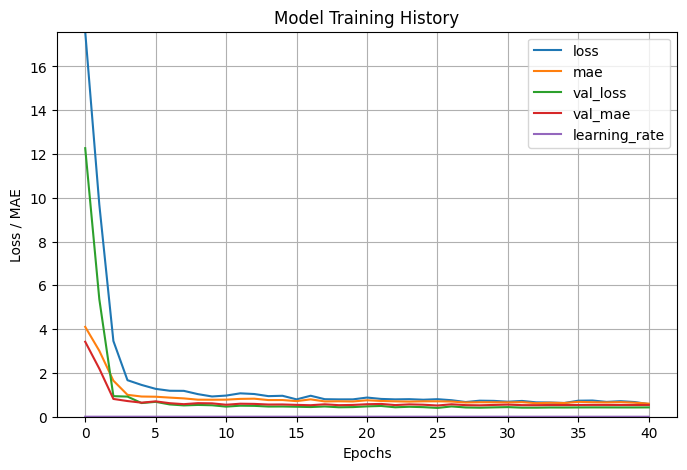

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# === Dummy Data Generation (Replace with your actual data) ===
# Create dummy data that resembles the structure mentioned in the proposal
# Assuming features like density, diversity, income, sv_index, etc.
# and a target variable 'robotaxi_trips'

df_cleaned=gdf_tracts
# Separate X and Y
X = df_cleaned.drop(columns=['Tract_ID', 'geometry', 'crash_coun','Area_km2','TripStart_', 'TripEnd_de', 'TripStart', 'TripEnd'])
X = X.apply(pd.to_numeric, errors='coerce')  # 强制转为数值型，非法值变成 NaN

# Instead of dropping all columns with ANY NaNs, drop only rows with NaNs:
X = X.dropna(axis=0, how='any')  # 去掉还有 NaN 的行

y_new = df_cleaned['TripStart_'][X.index]  # Align y_new with X's index



np.random.seed(42)
num_samples = 500 # Example number of census tracts
num_features = 15 # Example number of features (socio-dem, 5Ds, SVI)

# Generate random feature data
X_data = np.random.rand(num_samples, num_features) * 100

# Generate a plausible target variable (e.g., influenced by some features)
# Using a simple linear combination + noise + log transform simulation
y_target = (
    X_data[:, 0] * 0.5 + # Density influence
    X_data[:, 2] * 0.8 + # Income influence
    X_data[:, 5] * 0.3 + # Diversity influence
    np.random.randn(num_samples) * 20 # Noise
)
# Ensure target is non-negative before log transform
y_target[y_target < 1] = 1
y_log_target = np.log(y_target) # Log transform the target variable

# Convert to pandas DataFrames (optional, but good practice)
feature_names = [f'feature_{i+1}' for i in range(num_features)]
X = pd.DataFrame(X_data, columns=feature_names)
y_log = pd.Series(y_log_target, name='log_robotaxi_trips')

print("Generated Data Shapes:")
print("X shape:", X.shape)
print("y_log shape:", y_log.shape)
print("\nSample Data (First 5 rows of X):")
print(X.head())
print("\nSample Data (First 5 rows of y_log):")
print(y_log.head())
# === End of Dummy Data Generation ===


# 1. Split data into training, validation, and testing sets
# Splitting into train (70%), validation (15%), test (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_log, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1765, random_state=42 # 0.15 / (1 - 0.15)
)

print("\nData Split Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# 2. Standardize the features
# Use StandardScaler to scale features based on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. Define the improved neural network model
# Added Dropout layers for regularization
model = keras.Sequential([
    # Input layer - specify input shape based on scaled training data
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    # Dense hidden layer 1
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3), # Dropout layer 1
    # Dense hidden layer 2
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3), # Dropout layer 2
    # Dense hidden layer 3 (optional, can experiment)
    keras.layers.Dense(32, activation='relu'),
    # Output layer with a single neuron for regression (no activation for regression)
    keras.layers.Dense(1)
])

# 4. Compile the model
# Using Adam optimizer, Mean Squared Error loss
# Adding Mean Absolute Error as an additional metric
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Print model summary
model.summary()

# 5. Define Callbacks
# EarlyStopping to prevent overfitting and stop training early
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=15,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau to reduce learning rate when a metric has stopped improving
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001 # Lower bound on the learning rate.
)


# 6. Train the model
# Increased epochs, using validation data and callbacks
history = model.fit(X_train_scaled, y_train,
                    epochs=200, # Increased epochs, early stopping will handle overfitting
                    batch_size=32,
                    validation_data=(X_val_scaled, y_val), # Provide validation data
                    callbacks=[early_stopping_cb, reduce_lr_cb], # Use callbacks
                    verbose=1) # Set verbose=1 to see training progress


# 7. Make predictions on the test set
y_pred_log = model.predict(X_test_scaled)

# If your original target variable 'y' was log-transformed,
# you might want to transform predictions back to the original scale
# y_pred_original_scale = np.exp(y_pred_log)
# y_test_original_scale = np.exp(y_test)
# Note: Evaluate metrics on the scale used for training (log scale often preferred for skewed data)
# or evaluate on original scale depending on your goal. We evaluate on log scale here.

# 8. Evaluate the model on the test set (using log-transformed values)
r2 = r2_score(y_test, y_pred_log)
mse = mean_squared_error(y_test, y_pred_log)
mae = mean_absolute_error(y_test, y_pred_log)

print("\n--- Model Evaluation on Test Set ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Optional: Plot training history
try:
    import matplotlib.pyplot as plt
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss'])) # Adjust y-axis limits if needed
    plt.title("Model Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / MAE")
    # plt.show() # Display the plot if running locally
    print("\nTraining history plot generated (display depends on environment).")
except ImportError:
    print("\nMatplotlib not found. Skipping history plot.")

